# 반도체 공정 불량검출

https://www.kaggle.com/datasets/qingyi/wm811k-wafer-map/data

- 웨이퍼의 불량 종류를 분류

In [1]:
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install mglearn
import mglearn

# 음수표현 라이브러리
plt.rcParams['axes.unicode_minus'] = False

# 경고무시
import warnings
warnings.filterwarnings("ignore")

# 매직명령어 : 시각화 결과가 노트북에 포함되도록
%matplotlib inline

# 데이터 로딩

In [2]:
df=pd.read_pickle("LSWMD.pkl")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


# 데이터 탐색

In [3]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]


## 6개의 컬럼 의미 탐색

In [4]:
df.columns

Index(['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trianTestLabel',
       'failureType'],
      dtype='object')

In [5]:
df.columns = ['waferMap', 'dieSize', 'lotName', 'waferIndex', 'trainTestLabel',
       'failureType']

In [6]:
df.isnull().sum()

waferMap          0
dieSize           0
lotName           0
waferIndex        0
trainTestLabel    0
failureType       0
dtype: int64

### 2번 컬럼 dieSize

- dieSize는 하나의 wafer에서 칩의 사이즈를 의미한다.
- 하나의 wafer내에서 dieSize는 동일하다.

In [7]:
df[['dieSize']].describe()

,dieSize
count,811457.000000
mean,1840.998585
std,2254.987374
min,3.000000
25%,710.000000
50%,953.000000
75%,1902.000000
max,48099.000000


- dieSize는 일정하지 않음 -> waferMap의 크기가 일정하지 않을 수 있다.
- 평균과 3분위 수의 값이 비슷하며 최댓값이 매우크다. -> 이상치 고려

### 1번 컬럼 waferMap

- waferMap은 하나의 행마다 wafer하나의 이미지를 배열형태로 담고있다.

- dieSize의 크기가 일정하지 않으므로 waferMap의 크기를 알아본다.

In [8]:
def find_dim(x):
    dim = x.shape
    return dim
df['waferMapDim']=df.waferMap.apply(find_dim)
df.sample(5)

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,waferMapDim
399069,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3524.0,lot23872,10.0,[],[],"(74, 61)"
81416,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",776.0,lot5858,21.0,[],[],"(30, 34)"
682231,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,...",843.0,lot42300,14.0,[],[],"(35, 31)"
138915,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1126.0,lot9044,12.0,[],[],"(36, 41)"
513137,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,...",515.0,lot32053,21.0,[],[],"(25, 27)"


In [9]:
len(df.waferMapDim.unique())

632

In [10]:
np.unique(df.waferMap[0].ravel(), return_counts=True)

(array([0, 1, 2], dtype=uint8), array([ 477, 1595,   88], dtype=int64))

- 사진 속 빈 공간은 0
- 정상 wafer는 1
- 결함 wafer는 2

### 3번 컬럼 lotName

- lot은 wafer 25개를 담는 통을 말한다.
- 반도체 공정은 lot을 통째로 넣고 공정을 하는 경우도 있기 때문에 lotName이 같다면 결함 종류가 같을 확률이 높을 수 있다.(검증 필요)
- 같은 lot 내의 wafersize는 동일하다.

In [11]:
# waferIndex는 동일한 lotName에 최대 25개씩 들어가 있어야한다.
df.waferIndex.value_counts()

6.0     32745
4.0     32714
5.0     32701
7.0     32672
2.0     32663
8.0     32650
11.0    32637
9.0     32636
3.0     32621
12.0    32598
10.0    32586
1.0     32516
13.0    32381
16.0    32362
14.0    32353
17.0    32333
18.0    32333
21.0    32320
22.0    32312
15.0    32301
20.0    32290
19.0    32285
23.0    32202
24.0    32197
25.0    32049
Name: waferIndex, dtype: int64

In [12]:
# lotName열의 unique 개수
df['lotName'].nunique()

46293

In [13]:
46293*25 - df.shape[0]

345868

- 하나의 lot에 25개가 전부 들어가있지는 않다.

In [14]:
# df_1000 = df.tail(300)
# # failureNum은 failureType을 레이블인코딩을 한 것(뒤에서 진행)
# df_1000.groupby('lotName')['failureNum'].value_counts()

- lot47542의 경우 8:11, 3:7, 2:6, 0:1 과 같이 골고루 나왔다.
- 따라서 lotName이 같은 경우 공정에 영향을 끼칠 것이라는 가설은 유의미하지 않다.

### 4번 컬럼 waferIndex

- waferIndex의 의미의 가능성은 1. 하나의 lot의 wafer 식별번호, 2. 하나의 lot의 wafer 위치

In [15]:
df.head()

,waferMap,dieSize,lotName,waferIndex,trainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)"


In [16]:
waferindex = pd.DataFrame(df.waferIndex.value_counts())
waferindex.describe()

,waferIndex
count,25.000000
mean,32458.280000
std,198.200135
min,32049.000000
25%,32312.000000
50%,32381.000000
75%,32637.000000
max,32745.000000


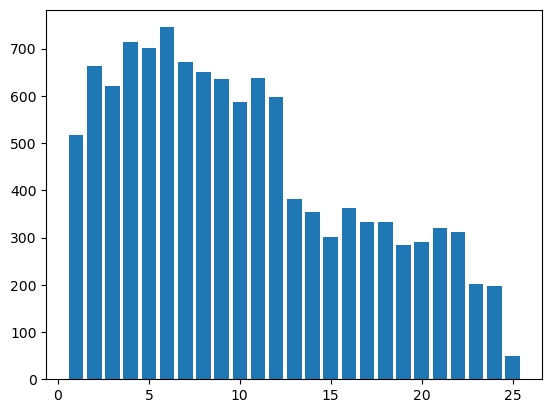

In [17]:
# lot에 들어있는 wafer개수 분포
plt.bar(waferindex.sort_index().index,waferindex.sort_index().waferIndex-32000)
plt.show()

#### waferIndex는 하나의 lot 내의 위치를 뜻함

- 하나의 lot내의 위치를 뜻하게 되면 lot내의 wafer 개수가 다를 때마다 정렬기준이 달라지며
- 단일 wafer공정의 경우 영향을 받지 않는다.
- 또한 가운데 정렬을 할지 균등분할을 할 지와 같은 정렬기준은 공정 상황에 따라 다르므로 중요도가 낮다고 판별됨

In [18]:
df.drop('waferIndex',axis=1,inplace=True)

### 5번째 컬럼 trainTestLabel

- train과 test을 구분해놓은 열이다. 따로 테스트파일이 없는 것을 보아 이 열의 결측치를 테스트파일로 쓰면 될 것같다.
- 아래의 6번째 컬럼의 결측이랑 동일한 위치에 있다면 가능하다.

In [19]:
df.trainTestLabel

0         [[Training]]
1         [[Training]]
2         [[Training]]
3         [[Training]]
4         [[Training]]
              ...     
811452        [[Test]]
811453        [[Test]]
811454        [[Test]]
811455              []
811456              []
Name: trainTestLabel, Length: 811457, dtype: object

- 처음에 isnull()로 없다고 나온 결측은 []형태로 있다.

In [20]:
df['trainTestLabel'].apply(lambda x: x.shape == (0, 0)).sum()

638507

In [21]:
1- 638507/df['trainTestLabel'].count()

0.2131351383992004

- train_test로 라벨링된 것의 비율은 21.3%밖에 되지 않는다.
- [[]]형태로 데이터가 구성되어 있으니 이를 처리하고 value_counts()를 통해 train, test비율을 본다.

In [22]:
df_tt = df['trainTestLabel'].apply(lambda x: str(x))
df_tt.head()

0    [['Training']]
1    [['Training']]
2    [['Training']]
3    [['Training']]
4    [['Training']]
Name: trainTestLabel, dtype: object

In [23]:
df_tt.value_counts()

[]                638507
[['Test']]        118595
[['Training']]     54355
Name: trainTestLabel, dtype: int64

#### 결측치 비율이 높으며 train 데이터에 비해 test 데이터 비율이 높다.

### 6번 컬럼 failureType

- 결함이 있는지 없는지를 나타내는 컬럼이며 있다면 종류를 나타낸다.

In [24]:
df.failureType

0              [[none]]
1              [[none]]
2              [[none]]
3              [[none]]
4              [[none]]
              ...      
811452    [[Edge-Ring]]
811453     [[Edge-Loc]]
811454    [[Edge-Ring]]
811455               []
811456               []
Name: failureType, Length: 811457, dtype: object

- 이전 열과같은 형태로 데이터가 구성되어 있다.

In [25]:
df_ft = df['failureType'].apply(lambda x: str(x))
df.head()

,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[none]],"(45, 48)"


In [26]:
df_ft.value_counts()

[]                 638507
[['none']]         147431
[['Edge-Ring']]      9680
[['Edge-Loc']]       5189
[['Center']]         4294
[['Loc']]            3593
[['Scratch']]        1193
[['Random']]          866
[['Donut']]           555
[['Near-full']]       149
Name: failureType, dtype: int64

#### 결측치 비율이 높으며 결함 종류는 8가지이다.

- none은 결함이 없음을 의미한다.

In [27]:
df[df_ft=='[]'].index

Int64Index([    35,     45,     69,    120,    158,    159,    161,    163,
               165,    166,
            ...
            811051, 811052, 811053, 811054, 811252, 811316, 811322, 811354,
            811455, 811456],
           dtype='int64', length=638507)

In [28]:
(df[df_ft=='[]'].index == df[df_tt=='[]'].index).sum()

638507

- trainTestLabel컬럼과 failureType컬럼의 결측의 인덱스가 동일하므로 결측치를 테스트파일로 써도 될 것

## 데이터 셋 분리

In [29]:
from sklearn.preprocessing import LabelEncoder

le1 = LabelEncoder()
df['failureNum'] = le1.fit_transform(df_ft)

le2 = LabelEncoder()
df['trainTestNum'] = le2.fit_transform(df_tt)

print(le1.classes_)
print(le2.classes_)

["[['Center']]" "[['Donut']]" "[['Edge-Loc']]" "[['Edge-Ring']]"
 "[['Loc']]" "[['Near-full']]" "[['Random']]" "[['Scratch']]" "[['none']]"
 '[]']
["[['Test']]" "[['Training']]" '[]']


In [30]:
le1.transform(le1.classes_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [31]:
# 결측치를 제외한 전체
df_withlabel = df[df['failureNum']<9].copy()
df_withlabel = df_withlabel.reset_index()
# none패턴과 결측치를 제외
df_withpattern = df[df['failureNum']<8].copy()
df_withpattern = df_withpattern.reset_index()
# none패턴
df_nonepattern = df[df['failureNum']==8].copy()
# 결측치
test = df[df['failureNum']==9].copy()

In [32]:
df_withlabel.shape[0], df_withpattern.shape[0], df_nonepattern.shape[0], test.shape[0]

(172950, 25519, 147431, 638507)

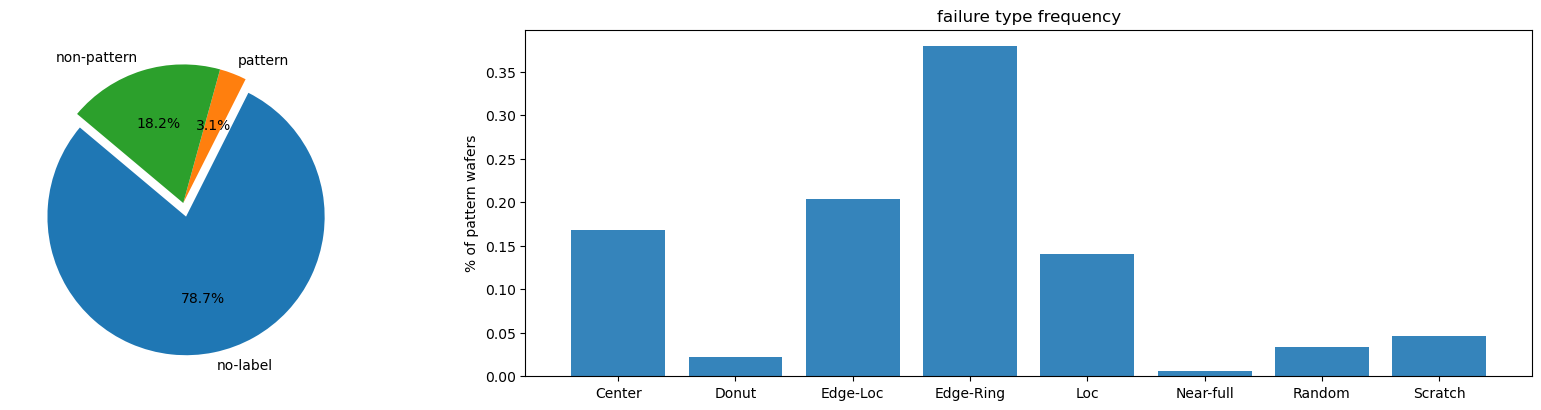

In [33]:
from matplotlib import gridspec
fig = plt.figure(figsize=(20, 4.5)) 

# gridspec(1,2, width_ratios=1, 2.5)는 1행 2열의 서브플롯을 만들고 그림 비율이 1:2.5라는 것이다.
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2.5]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

no_wafers=[test.shape[0], df_withpattern.shape[0], df_nonepattern.shape[0]]

# 파이차트에서 하나의 조각을 0.1 만큼 떨어뜨림
explode = (0.1, 0, 0) 
labels = ['no-label','pattern','non-pattern']

# 1행 1열
ax1.pie(no_wafers, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)

uni_pattern=np.unique(df_withpattern.failureNum, return_counts=True)
labels2 = ['','Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']

# 1행 2열
ax2.bar(uni_pattern[0],uni_pattern[1]/df_withpattern.shape[0], alpha=0.9)
ax2.set_title("failure type frequency")
ax2.set_ylabel("% of pattern wafers")
ax2.set_xticklabels(labels2)

plt.show()

- label이 되지 않은 데이터의 비율이 78.7%인 반면 pattern이 있는 데이터는 3.1%밖에 되지않는다.
- 데이터 불균형을 고려해야한다.

## WaferMap 시각화

### waferMap 100개의 샘플 시각화

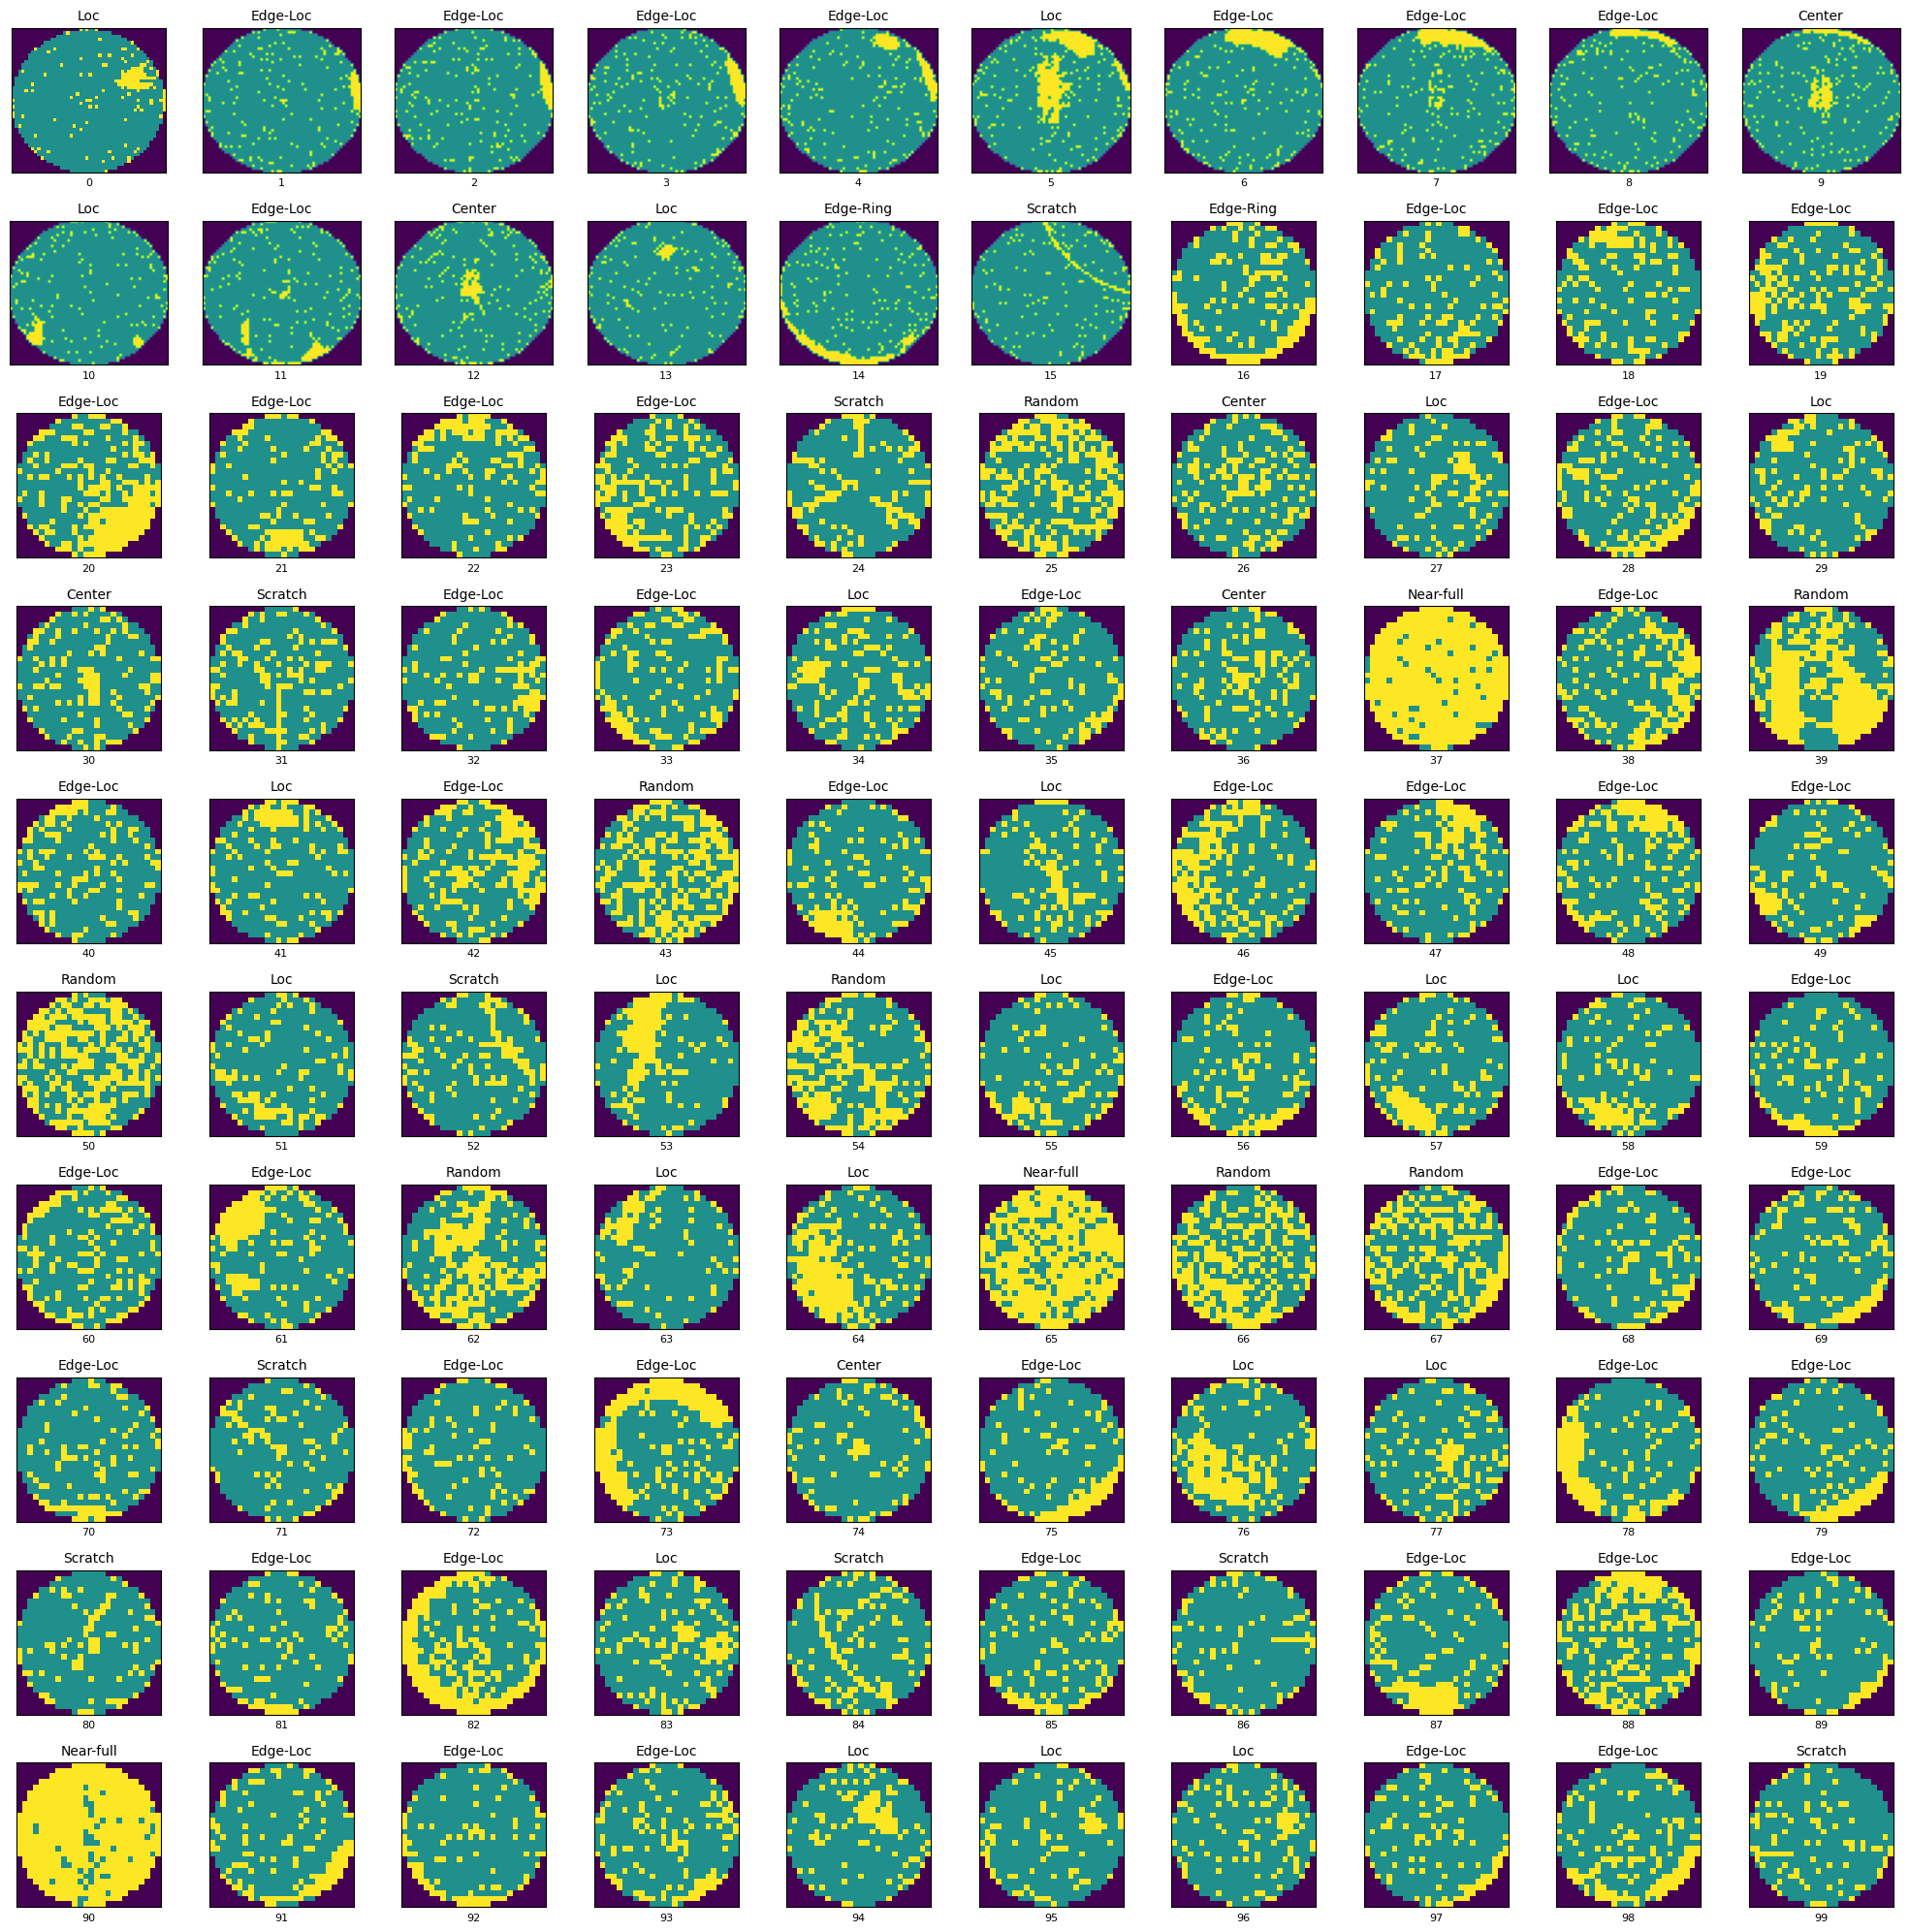

In [34]:
fig, ax = plt.subplots(nrows = 10, ncols = 10, figsize=(20, 20))
# 반복문을 보다 편리하게 사용 
ax = ax.ravel()
for i in range(100):
    img = df_withpattern.waferMap[i]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[i][0][0], fontsize=10)
    ax[i].set_xlabel(df_withpattern.index[i], fontsize=8)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

### waferMap의 failureType에 따른 시각화

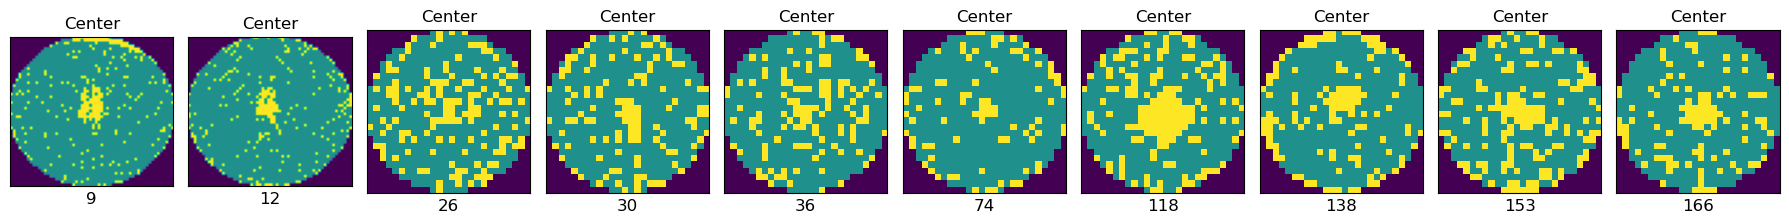

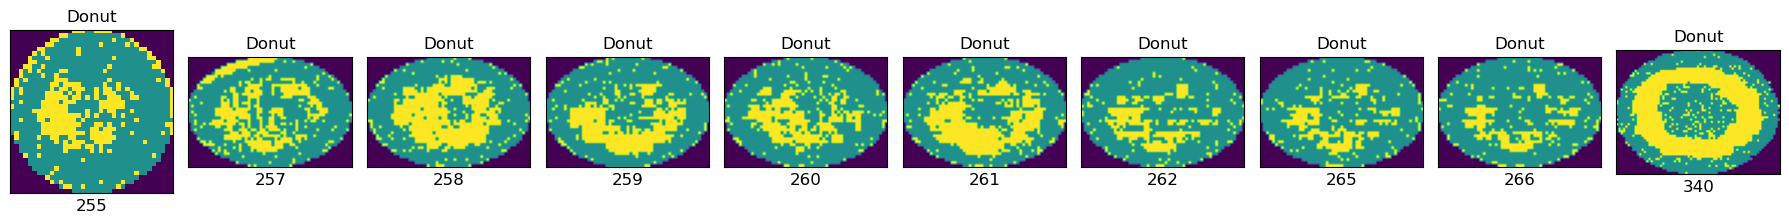

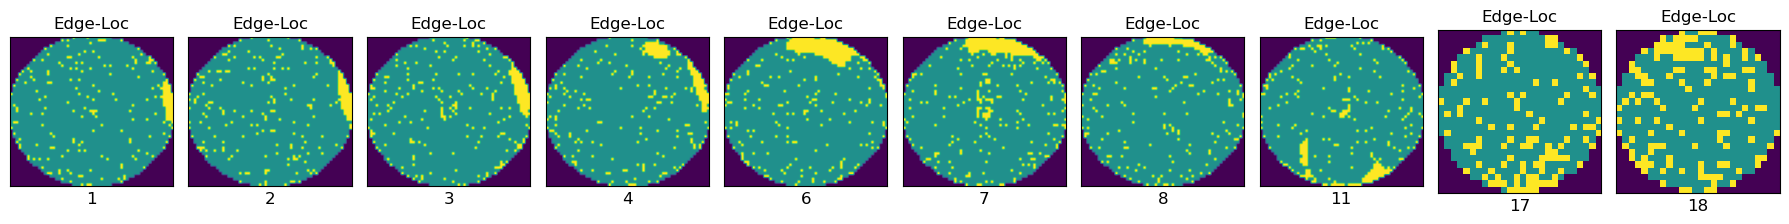

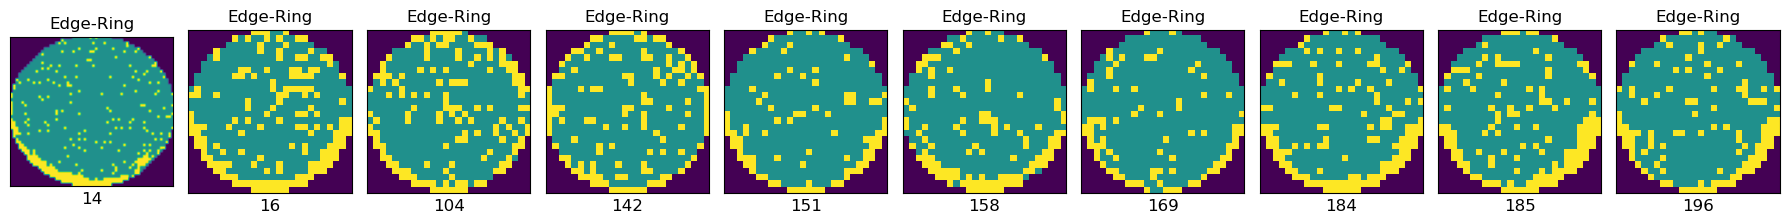

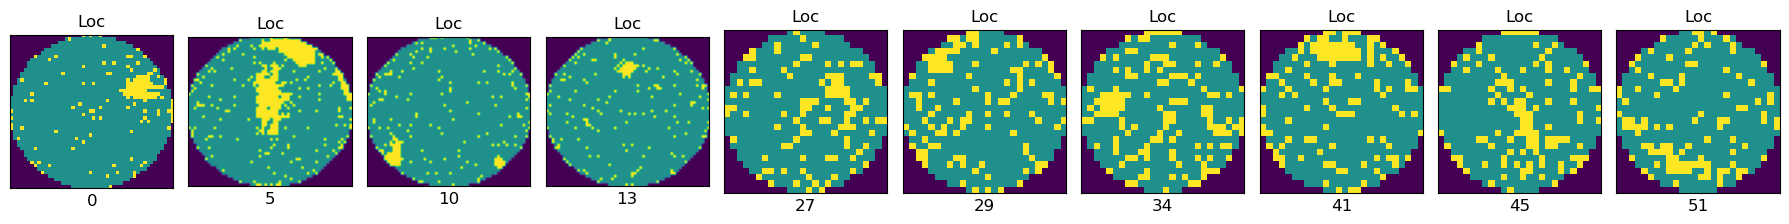

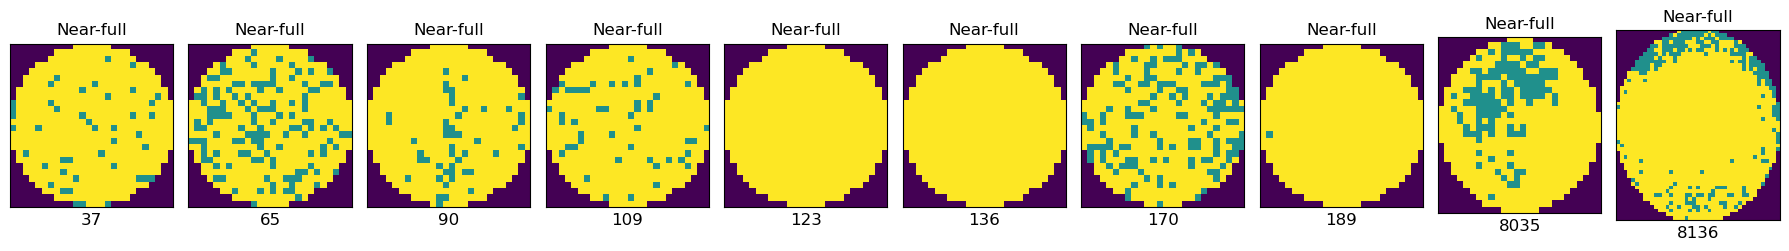

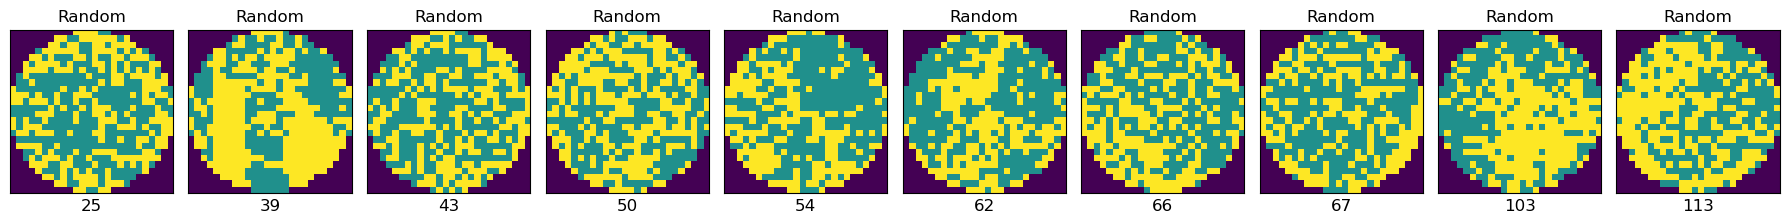

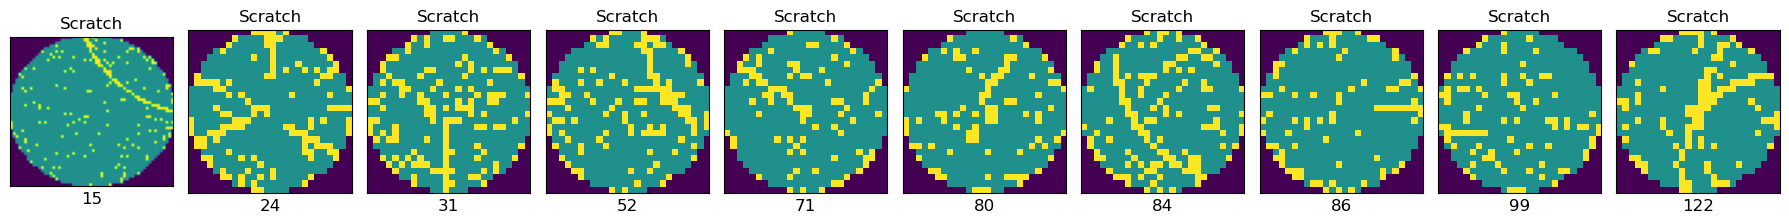

In [35]:
x = [0,1,2,3,4,5,6,7]
labels = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']

for k in x:
    fig, ax = plt.subplots(nrows = 1, ncols = 10, figsize=(18, 12))
    ax = ax.ravel()
    img = df_withpattern.waferMap[df_withpattern.failureType==labels[k]]
    for i in range(10):
        ax[i].imshow(img[img.index[i]])
        ax[i].set_title(df_withpattern.failureType[img.index[i]][0][0], fontsize=12)
        ax[i].set_xlabel(df_withpattern.index[img.index[i]], fontsize=12)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.tight_layout()
    plt.show()


#### failureType별로 특징적인 wafer 시각화

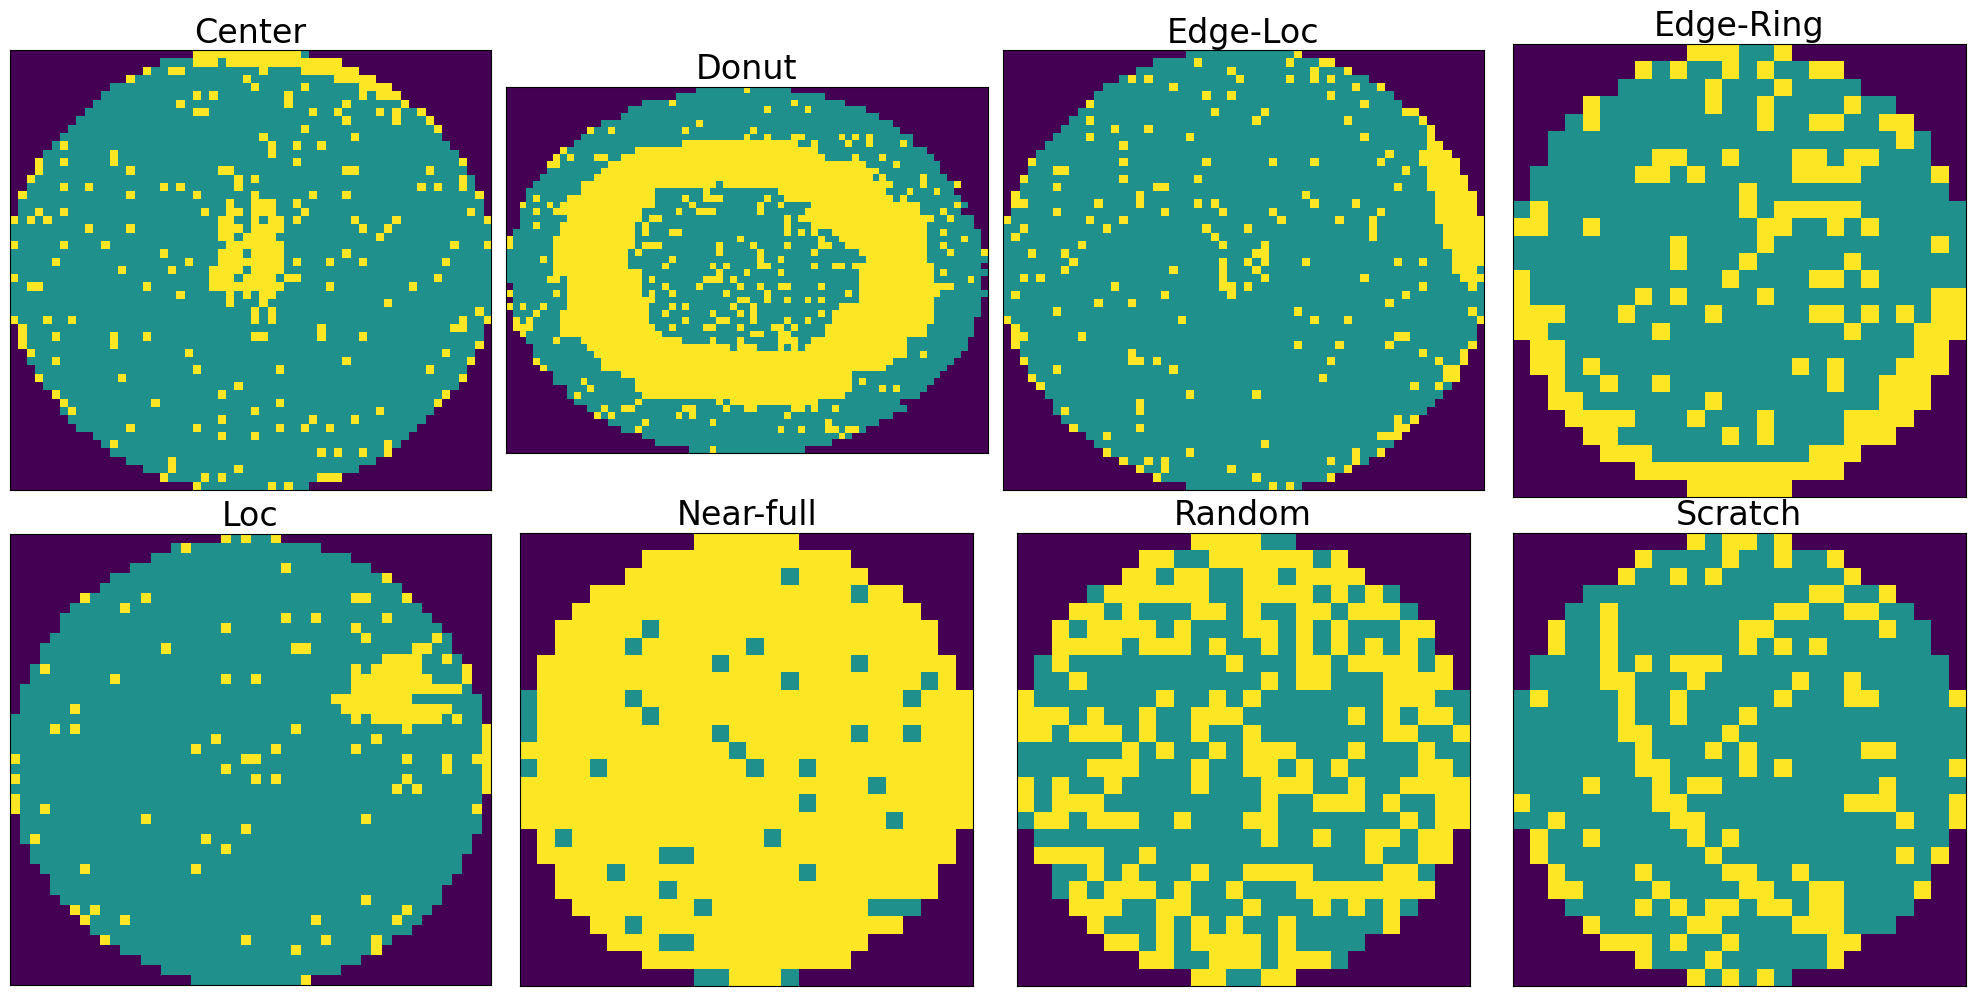

In [36]:
x = [9,340, 3, 16, 0, 37, 25, 84]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel()
for i in range(8):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show() 

# waferMap 전처리

- 위의 사진들을 보면 사이즈가 제각각인 것을 볼 수 있다.
- 머신러닝을 위해 사이즈를 맞춰줄 필요가 있다.

## 필수 라이브러리 로딩

In [37]:
# loading libraries
import skimage
from skimage import measure
from skimage.transform import radon
from skimage.transform import probabilistic_hough_line
from scipy import interpolate
from scipy import stats

## 이미지 전처리

- waferMap을 가운데가 3행 3열이 되도록 13부분으로 나눠서 분석할 예정
- 각 부분의 결함밀도를 확인하여 비교
- ex) center결함은 center부분에서 높은 결함밀도를 가짐

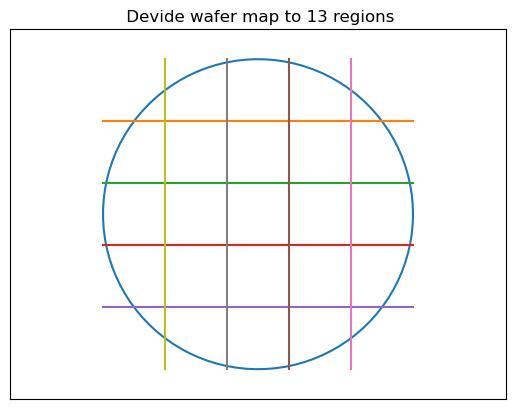

In [38]:
# 13개의 부분으로 나눠서 사진을 분석할 예정

an = np.linspace(0, 2*np.pi, 100)
# 반지름 2.5인 원
plt.plot(2.5*np.cos(an), 2.5*np.sin(an))

# x축과 y축의 좌표를 동일하게 설정하여 원형으로 보이게 함
plt.axis('equal')
plt.axis([-4, 4, -4, 4])
plt.plot([-2.5, 2.5], [1.5, 1.5])
plt.plot([-2.5, 2.5], [0.5, 0.5 ])
plt.plot([-2.5, 2.5], [-0.5, -0.5 ])
plt.plot([-2.5, 2.5], [-1.5,-1.5 ])

plt.plot([0.5, 0.5], [-2.5, 2.5])
plt.plot([1.5, 1.5], [-2.5, 2.5])
plt.plot([-0.5, -0.5], [-2.5, 2.5])
plt.plot([-1.5, -1.5], [-2.5, 2.5])
plt.title(" Devide wafer map to 13 regions")
plt.xticks([])
plt.yticks([])
plt.show()

In [39]:
# 결함밀도 계산함수
def cal_den(x):
    # waferMap의 결함(2)인 부분의 밀도
    return 100*(np.sum(x==2)/np.size(x))  

# 13분할을 하여 구역을 찾는 함수
def find_regions(x):
    rows=x.shape[0]
    cols=x.shape[1]
    
    # 5분할
    ind1=np.arange(0,rows,rows//5)
    ind2=np.arange(0,cols,cols//5)
    
    reg1=x[:ind1[1], :]
    reg3=x[ind1[4]:, :]
    reg4=x[:, :ind2[1]]
    reg2=x[:, ind2[4]:]

    reg5=x[ind1[1]:ind1[2],ind2[1]:ind2[2]]
    reg6=x[ind1[1]:ind1[2],ind2[2]:ind2[3]]
    reg7=x[ind1[1]:ind1[2],ind2[3]:ind2[4]]
    reg8=x[ind1[2]:ind1[3],ind2[1]:ind2[2]]
    reg9=x[ind1[2]:ind1[3],ind2[2]:ind2[3]]
    reg10=x[ind1[2]:ind1[3],ind2[3]:ind2[4]]
    reg11=x[ind1[3]:ind1[4],ind2[1]:ind2[2]]
    reg12=x[ind1[3]:ind1[4],ind2[2]:ind2[3]]
    reg13=x[ind1[3]:ind1[4],ind2[3]:ind2[4]]
    
    fea_reg_den = []
    for name in [reg1,reg2,reg3,reg4,reg5,reg6,reg7,reg8,reg9,reg10,reg11,reg12,reg13]:
        fea_reg_den.append(cal_den(name))
    return fea_reg_den

In [40]:
df_withpattern['fea_reg']=df_withpattern.waferMap.apply(find_regions)

### failureType별 특징 적인 wafer시각화

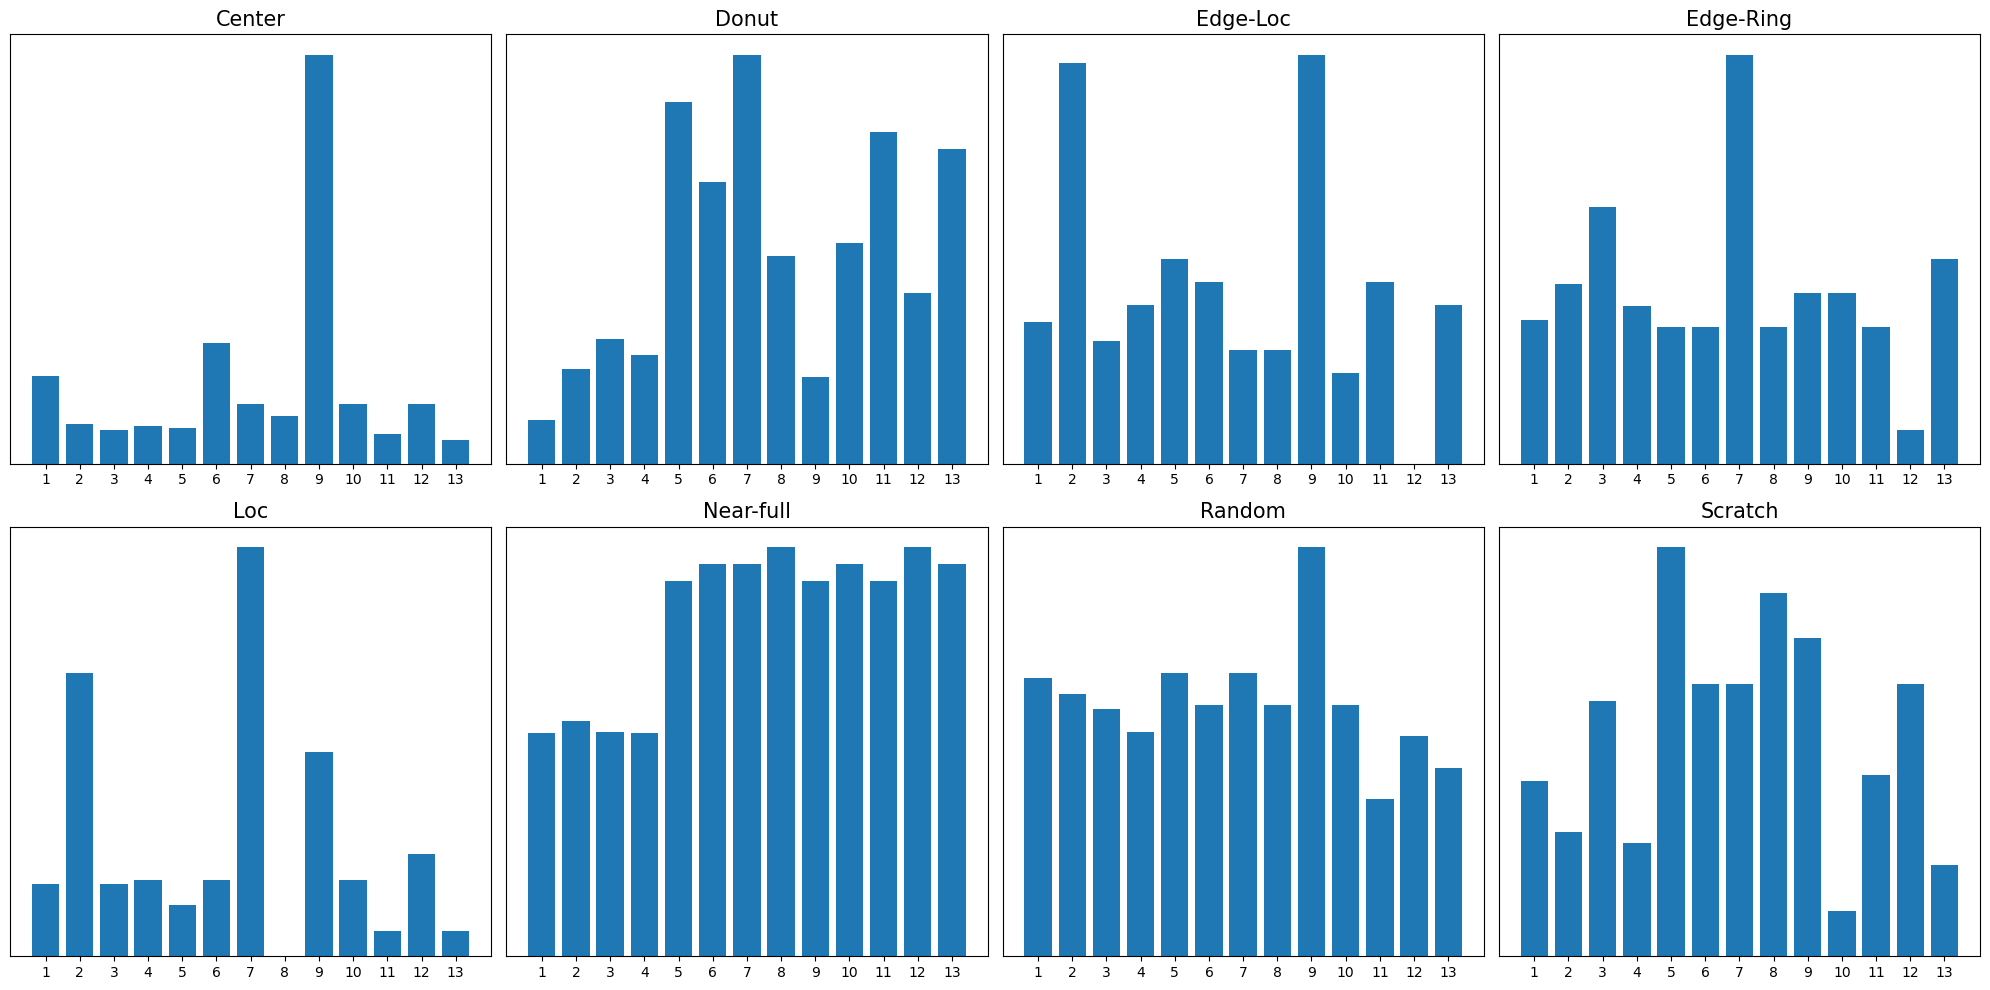

In [41]:
x = [9,340, 3, 16, 0, 37, 25, 84]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']
bar_positions = np.arange(1, 14)

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel()
for i in range(8):
    ax[i].bar(np.linspace(1,13,13),df_withpattern.fea_reg[x[i]])
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks(bar_positions)
    ax[i].set_xticklabels(range(1, 14)) 
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

## 라돈 변환

1. 각도를 선택한다. np.linspace(0., 180., max(img.shape), endpoint=False)
2. waferMap의 배열을 각도만큼 회전변환을 진행한다.
3. 회전된 배열의 행을 기준으로 합을 구하여 그 데이터를 열로 누적한다.
4. 설정한 각도범위로 이미지를 본다.

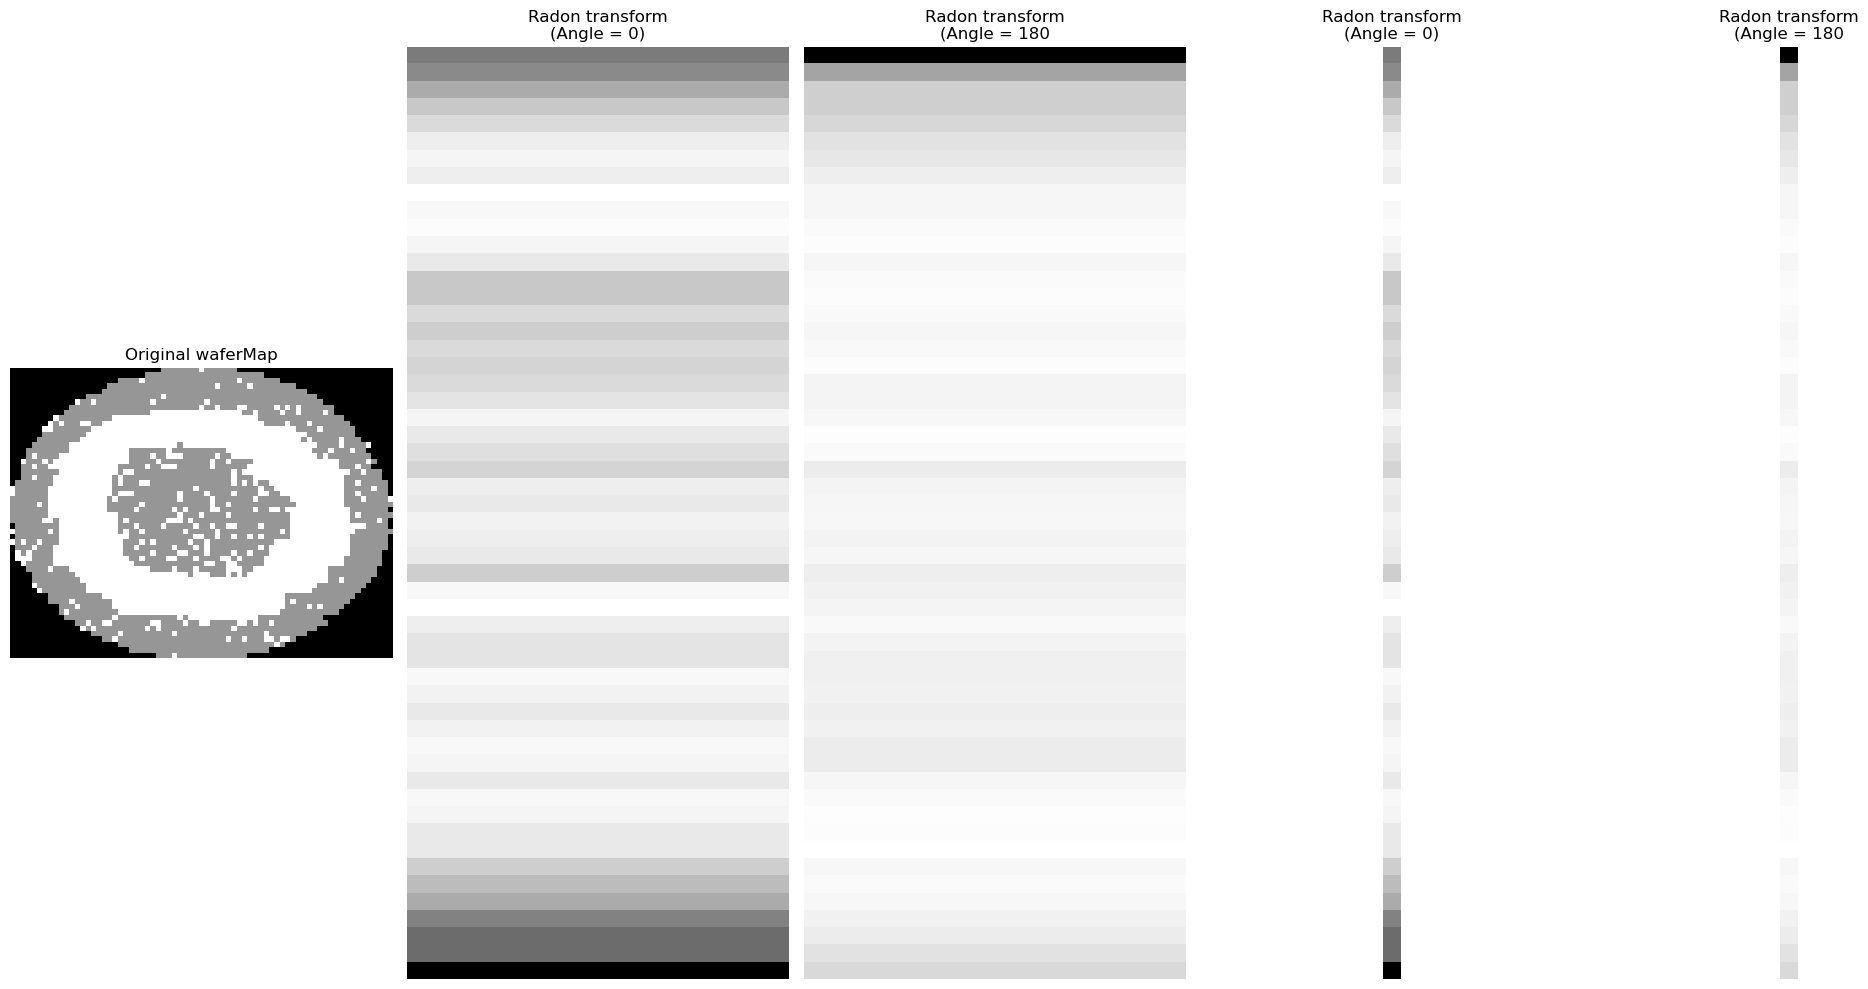

In [174]:
# 라돈 변환 두 개의 각도에서 예시
sample = df_withpattern.waferMap[340]

# 0도
sinogram1 = radon(sample, theta=[0])
# 180도
sinogram2 = radon(sample, theta=[180])

fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1, 5, figsize=(20,10)) 


ax1.imshow(sample, cmap=plt.cm.Greys_r)
ax1.set_title('Original waferMap')
ax1.set_axis_off()

ax2.set_title('Radon transform\n(Angle = 0)')
ax2.imshow(sinogram1, cmap=plt.cm.Greys_r, aspect='auto')
ax2.set_axis_off()

ax3.set_title('Radon transform\n(Angle = 180')
ax3.imshow(sinogram2, cmap=plt.cm.Greys_r, aspect='auto')
ax3.set_axis_off()

ax4.set_title('Radon transform\n(Angle = 0)')
ax4.imshow(sinogram1, cmap=plt.cm.Greys_r)
ax4.set_axis_off()

ax5.set_title('Radon transform\n(Angle = 180')
ax5.imshow(sinogram2, cmap=plt.cm.Greys_r)
ax5.set_axis_off()


plt.tight_layout()
plt.show()


In [43]:
def change_val(img):
    img_copy = img.copy()
    img_copy[img_copy==1] =0  
    return img_copy

df_withpattern_copy = df_withpattern.copy()
df_withpattern_copy['new_waferMap'] = df_withpattern_copy.waferMap.apply(change_val)

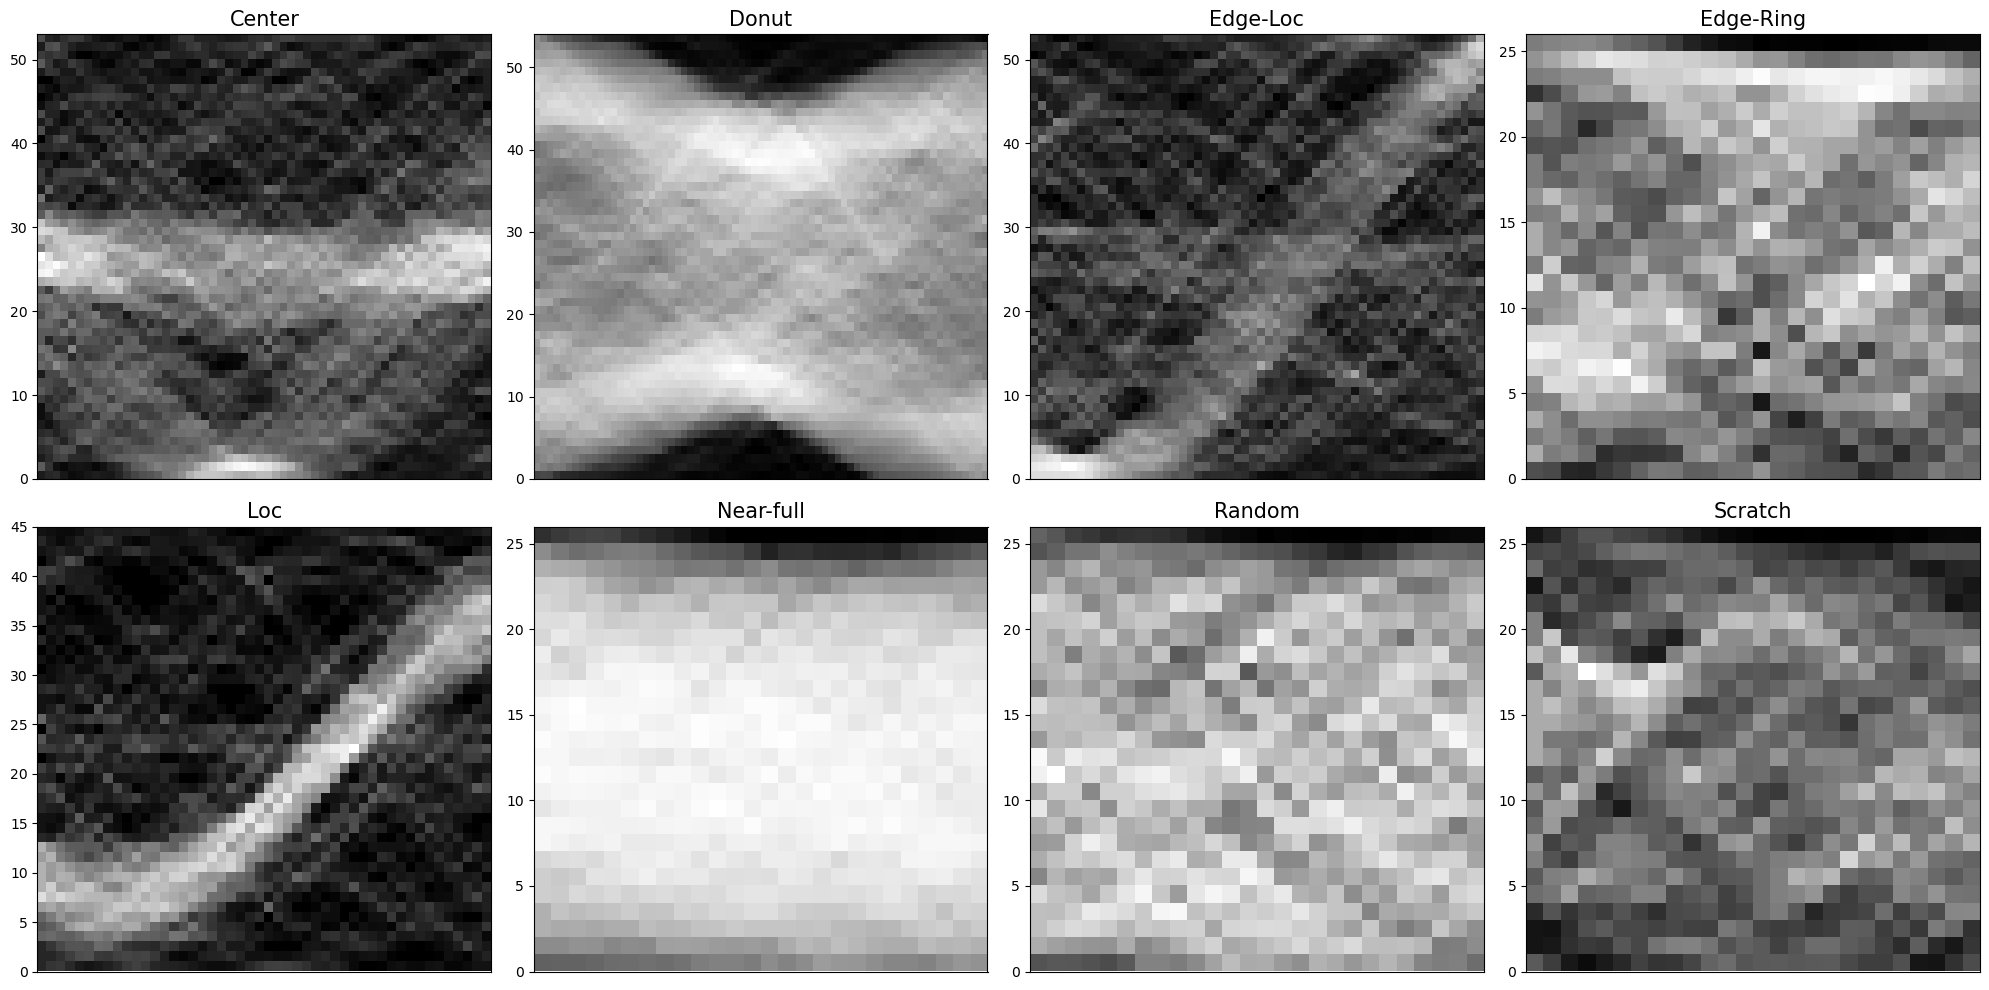

In [47]:
x = [9,340, 3, 16, 0, 37, 25, 84]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel()
for i in range(8):
    img = df_withpattern_copy.new_waferMap[x[i]]
    # 라돈 변환시 회전각도 설정
    theta = np.linspace(0., 180., max(img.shape), endpoint=False)
    # 라돈 변환 preserve_range=True를 사용하여 입력데이터의 타입과 값의 범위를 유지
    sinogram = radon(img, theta=theta, preserve_range=True)    
    
    ax[i].imshow(sinogram, cmap=plt.cm.Greys_r, extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=15)
    ax[i].set_xticks([])
plt.tight_layout()

plt.show()

### waferMap 사이즈 조정

In [48]:
def cubic_inter_mean(img):
    img_copy = img.copy()
    theta = np.linspace(0., 180., max(img_copy.shape), endpoint=False)
    sinogram = radon(img_copy, theta=theta)
    # radon변환의 행 평균
    xMean_Row = np.mean(sinogram, axis = 1)
    x = np.linspace(1, xMean_Row.size, xMean_Row.size)
    y = xMean_Row
    # x와 y로 3차 보간을 진행
    f = interpolate.interp1d(x, y, kind = 'cubic')
    # 원래의 데이터의 피처를 20개로 축소
    xnew = np.linspace(1, xMean_Row.size, 20)
    # 20개의 데이터로 3차보간한 값을 추출
    ynew = f(xnew)
    return ynew

def cubic_inter_std(img):
    img_copy = img.copy()
    theta = np.linspace(0., 180., max(img_copy.shape), endpoint=False)
    sinogram = radon(img_copy, theta=theta)
    # radon변환의 행 표준편차
    xStd_Row = np.std(sinogram, axis=1)
    x = np.linspace(1, xStd_Row.size, xStd_Row.size)
    y = xStd_Row
    f = interpolate.interp1d(x, y, kind = 'cubic')
    xnew = np.linspace(1, xStd_Row.size, 20)
    ynew = f(xnew)
    return ynew

In [49]:
df_withpattern_copy.shape

(25519, 11)

In [50]:
min(df_withpattern_copy.waferMapDim), max(df_withpattern_copy.waferMapDim)

((22, 35), (212, 84))

In [51]:
df_withpattern_copy = df_withpattern_copy[df_withpattern_copy.waferMapDim.apply(lambda x : (x[0]>24)&(x[1]>24))]

In [53]:
df_withpattern_copy['fea_cub_mean'] =df_withpattern_copy.new_waferMap.apply(cubic_inter_mean)
df_withpattern_copy['fea_cub_std'] =df_withpattern_copy.new_waferMap.apply(cubic_inter_std)

In [54]:
df_withpattern_copy.head()

,index,waferMap,dieSize,lotName,trainTestLabel,failureType,waferMapDim,failureNum,trainTestNum,fea_reg,new_waferMap,fea_cub_mean,fea_cub_std
0,19,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,[[Training]],[[Loc]],"(45, 48)",4,1,"[3.4722222222222223, 13.703703703703704, 3.472...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.008215024391397317, 0.01046398062887912, 0....","[0.004041707409884569, 0.006363021854617117, 0..."
1,36,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,1,"[6.0344827586206895, 11.05121293800539, 5.1724...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.02109536214678039, 0.02345828725981231, 0.0...","[0.014887071778255934, 0.01421232925195759, 0...."
2,37,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,1,"[5.862068965517241, 11.320754716981133, 5.0397...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.01733431456355848, 0.023660285913506465, 0....","[0.012072368578950261, 0.016439666475250848, 0..."
3,38,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,1,"[5.689655172413794, 16.037735849056602, 4.9071...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.02615744343762121, 0.027777062392136634, 0....","[0.01666441319079073, 0.022818644635532154, 0...."
4,39,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2460.0,lot2,[[Training]],[[Edge-Loc]],"(53, 58)",2,1,"[11.551724137931034, 13.07277628032345, 5.0397...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0.02512140845195993, 0.027318127047125836, 0....","[0.01206891136499179, 0.019005960944182505, 0...."


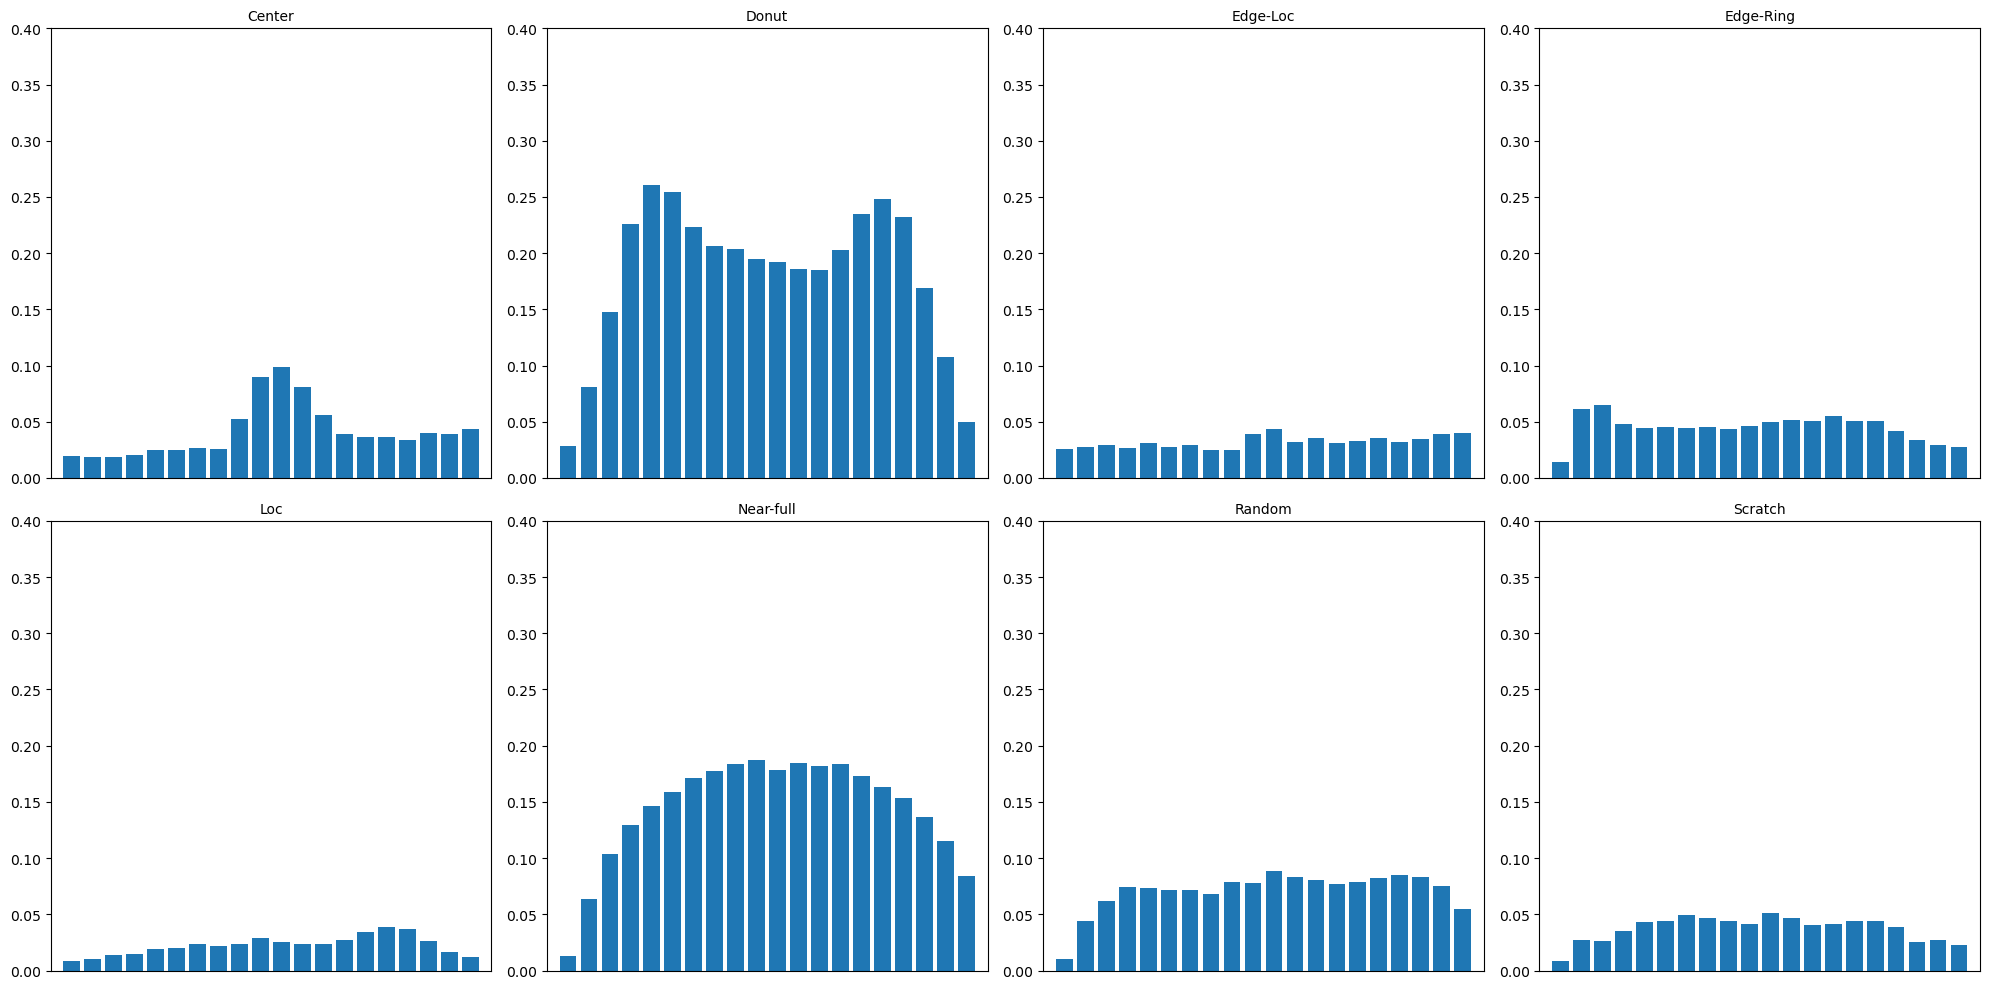

In [55]:
x = [9,340, 3, 16, 0, 37, 25, 84]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel()
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_mean[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.4])
plt.tight_layout()
plt.show() 

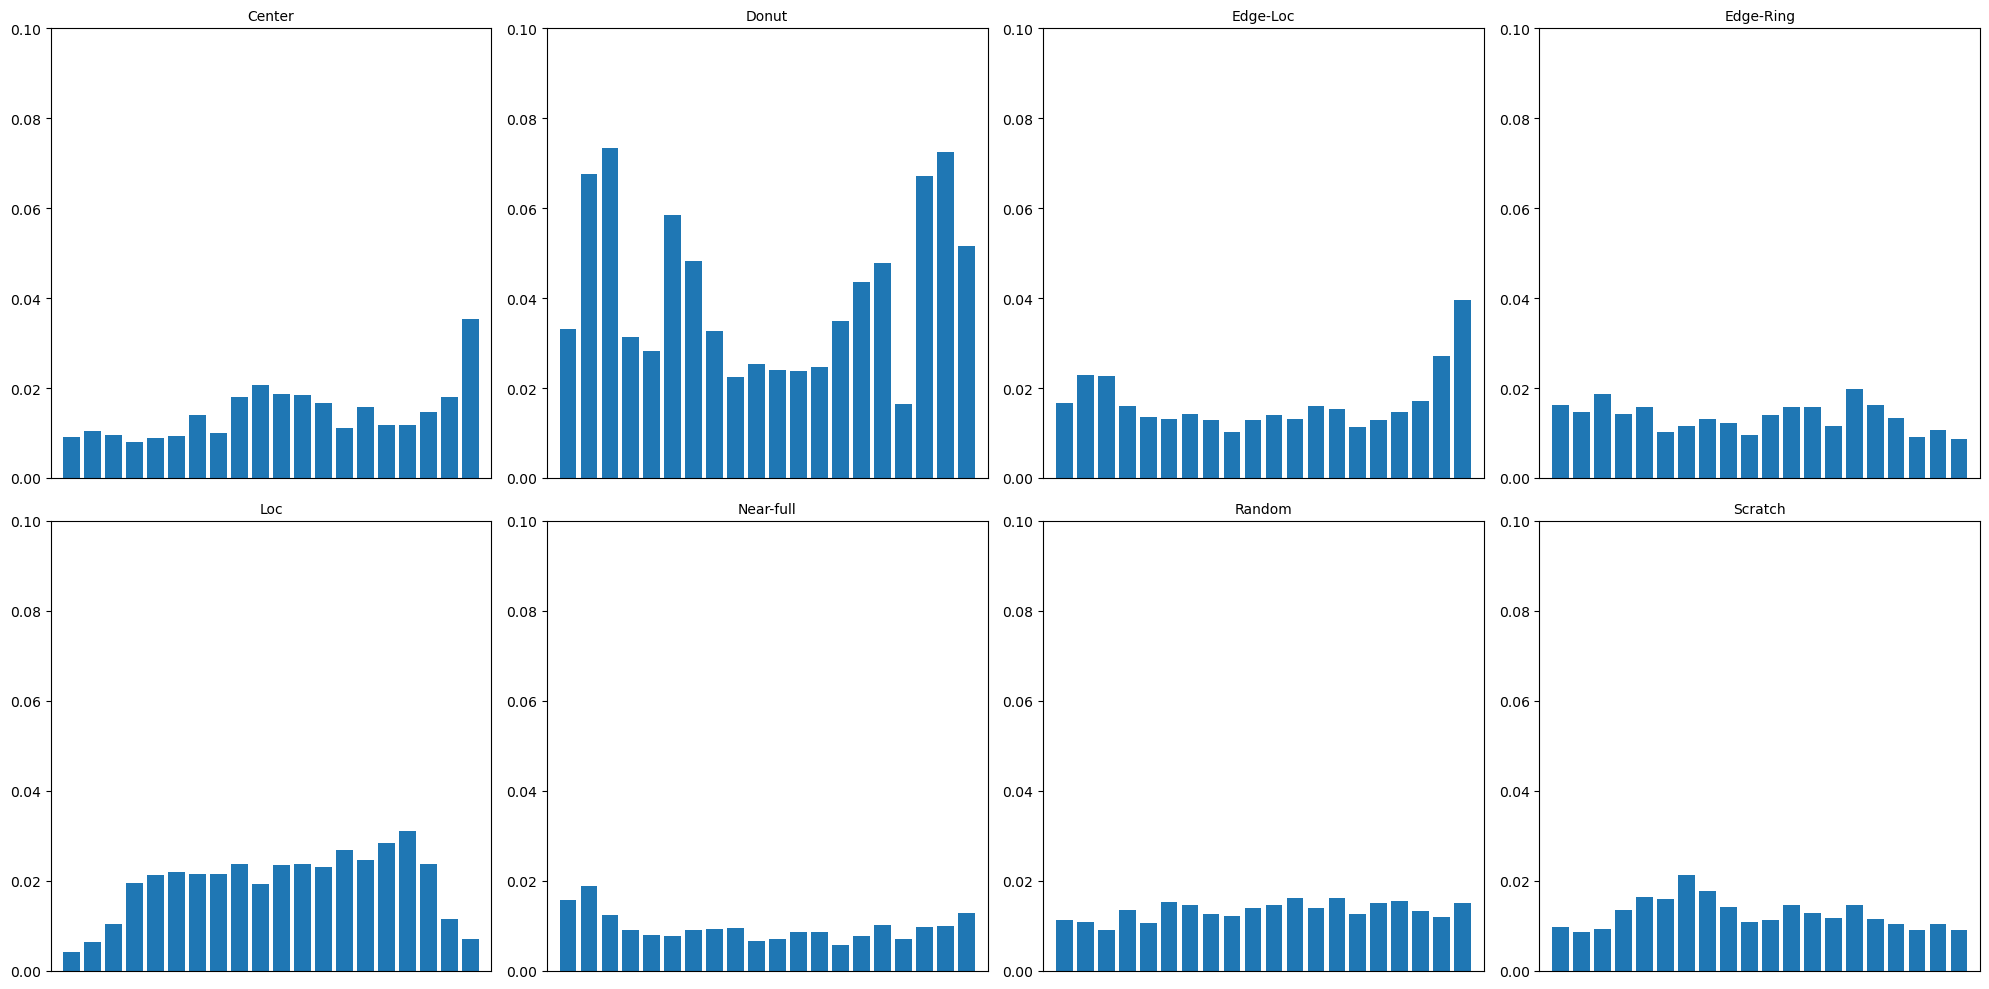

In [56]:
fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel()
for i in range(8):
    ax[i].bar(np.linspace(1,20,20),df_withpattern_copy.fea_cub_std[x[i]])
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
    ax[i].set_xlim([0,21])   
    ax[i].set_ylim([0,0.1])
plt.tight_layout()
plt.show() 

## 이미지 레이블링
<code>
>>> import numpy as np
>>> x = np.eye(3).astype(int)
>>> print(x)
[[1 0 0]
 [0 1 0]
 [0 0 1]]
>>> print(label(x, connectivity=1))
[[1 0 0]
 [0 2 0]
 [0 0 3]]
>>> print(label(x, connectivity=2))
[[1 0 0]
 [0 1 0]
 [0 0 1]]
>>> print(label(x, background=-1))
[[1 2 2]
 [2 1 2]
 [2 2 1]]
>>> x = np.array([[1, 0, 0],
...               [1, 1, 5],
...               [0, 0, 0]])
>>> print(label(x))
[[1 0 0]
 [1 1 2]
 [0 0 0]]  
</code>

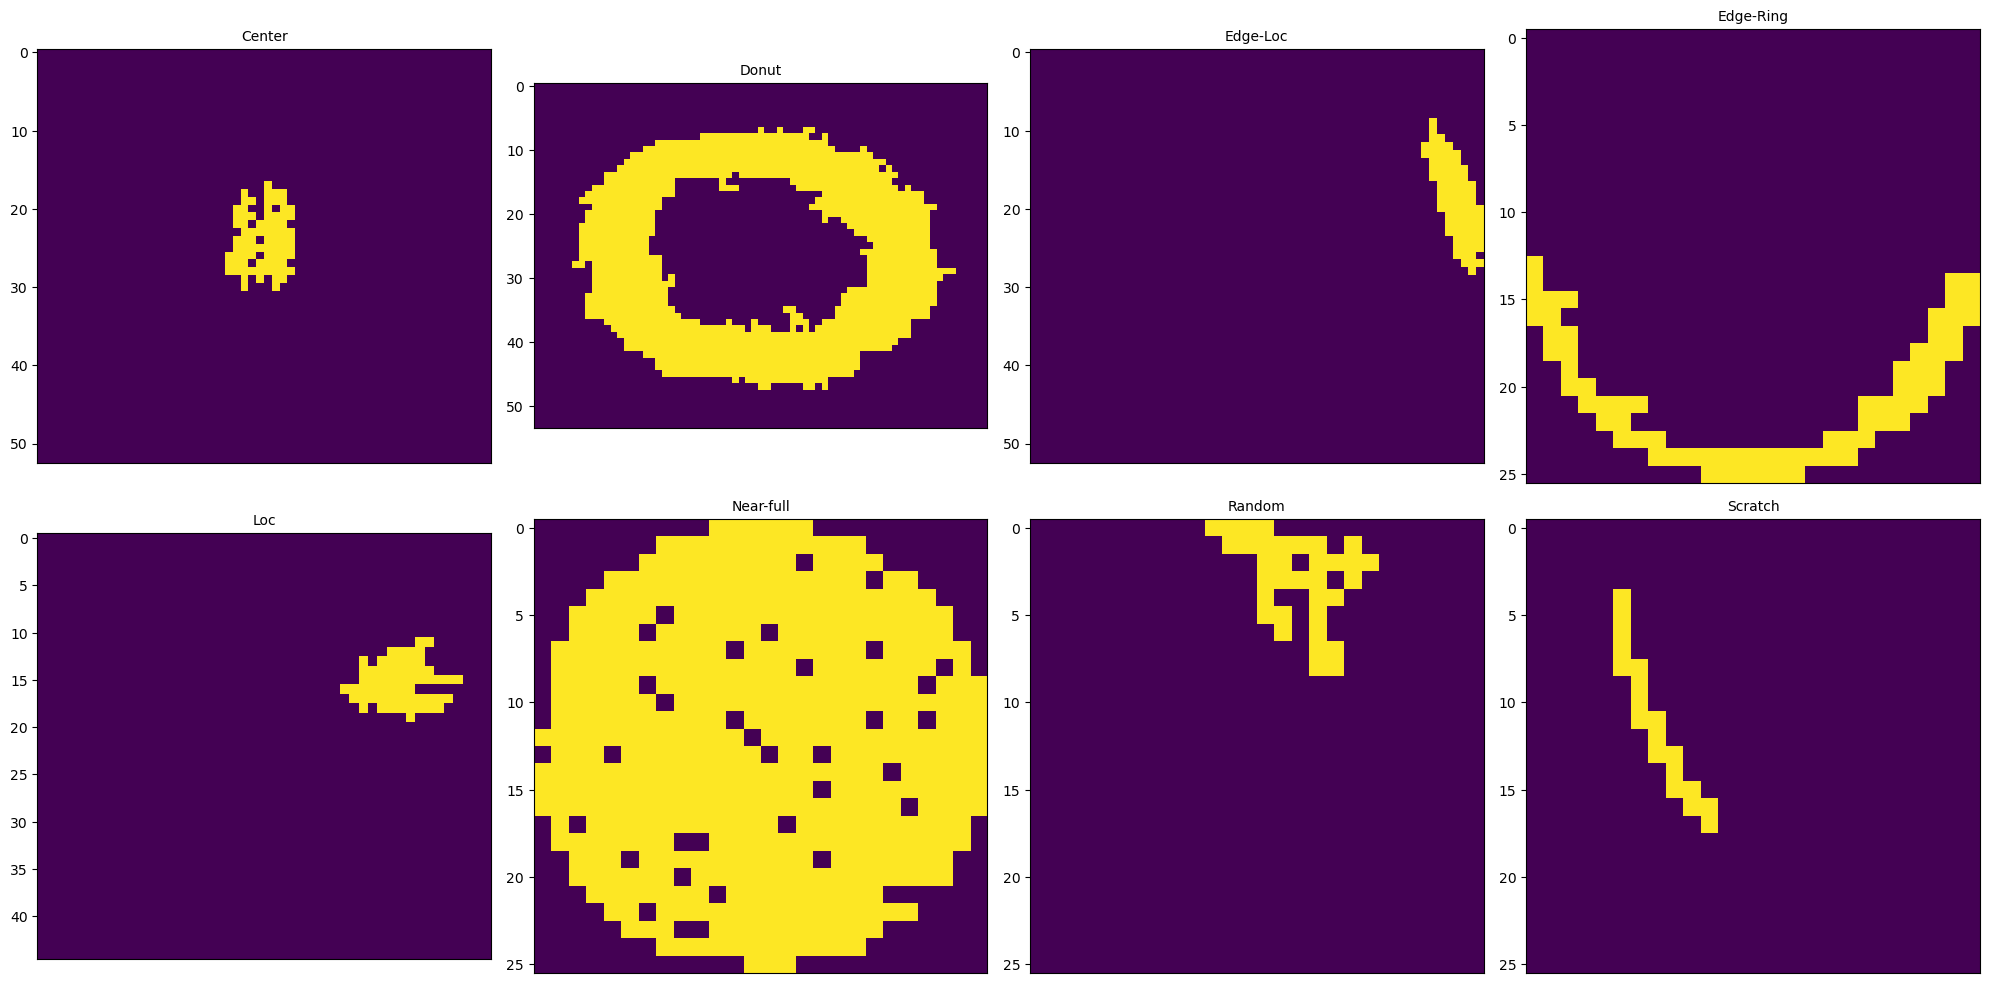

In [60]:
x = [9,340, 3, 16, 0, 37, 25, 84]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch']

fig, ax = plt.subplots(nrows = 2, ncols = 4,figsize=(20, 10))
ax = ax.ravel()
for i in range(8):
    img = df_withpattern_copy.new_waferMap[x[i]]
    zero_img = np.zeros(img.shape)
    
    img_labels = measure.label(img, connectivity=1, background=0)
    info_region = stats.mode(img_labels[img_labels>0], axis = None)
    no_region = info_region[0]
    
    # img_labels의 no_region부분을 zero_img에 2로 기입
    zero_img[np.where(img_labels==no_region)] = 2 
    ax[i].imshow(zero_img)
    ax[i].set_title(df_withpattern_copy.failureType[x[i]][0][0],fontsize=10)
    ax[i].set_xticks([])
plt.tight_layout()
plt.show() 

In [58]:
np.unique(sample, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([ 832, 1631, 1371], dtype=int64))

In [59]:
sample_labels = measure.label(sample, connectivity=1, background=0)
np.unique(sample_labels, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152], dtype=int64),
 array([ 832, 1093,    1,    1,    1,    1,    1,    1,    1,    1,    1,
           1, 1184,    1,    1,    2,    1,    1, 

## 이미지 속성 추출

- 위와 같이 라벨링된 이미지를 통해 구별을 하기 위해서는 이 라벨링 된 객체의 속성을 알아야한다.
- ex) 지름, 둘레, 넓이 등

In [81]:
sample2 = df_withpattern_copy.new_waferMap[0]
img_labels = measure.label(sample2, connectivity=1, background=0)
norm_area=sample2.size
info_region = stats.mode(img_labels[img_labels>0], axis = None)
no_region = info_region[0] -1

# 이미지의 속성을 담는 메서드 measure.regionprops
prop = measure.regionprops(img_labels)
# 라벨링된 면적비율
prop_area = prop[0].area/norm_area
prop[no_region].area

59

In [82]:
# 이미지의 중심에서 얼마나 떨어져있는가
def cal_dist(img,x,y):
    img_copy = img.copy()
    dim0=np.size(img_copy,axis=0)    
    dim1=np.size(img_copy,axis=1)
    dist = np.sqrt((x-dim0/2)**2+(y-dim1/2)**2)
    return dist  

# 기하학적 속성 추출함수
def fea_geom(img):
    img_copy = img.copy()
    # 가로 * 세로
    norm_area=img_copy.size
    # 대각선 길이
    norm_perimeter=np.sqrt((img_copy.shape[0])**2+(img_copy.shape[1])**2)
    
    img_labels = measure.label(img_copy, connectivity=1, background=0)

    info_region = stats.mode(img_labels[img_labels>0], axis = None)
    
    # 아래 prop. 속성값들을 호출할 때 0부터 시작하는 레이블을 기대하므로 1부터 레이블된 이미지레이블 값에서 1을 빼줌
    no_region = info_region[0]-1
    
    # 이미지의 속성을 담는 메서드 measure.regionprops
    prop = measure.regionprops(img_labels)
    # 라벨링된 면적비율
    prop_area = prop[no_region].area/norm_area
    # 4-연결 된 객체의 중심을 지나가는 선의 비율
    prop_perimeter = prop[no_region].perimeter/norm_perimeter 
    # local_centroid는 지역중심점으로 (x평균, y평균)
    prop_cent = prop[no_region].local_centroid 
    # prop_cent는 라벨링된 지역중심점과 전체 이미지의 중심까지의 거리
    prop_cent = cal_dist(img_copy,prop_cent[0],prop_cent[1])
    # 타원의 장축길이비율
    prop_majaxis = prop[no_region].major_axis_length/norm_perimeter 
    # 타원의 단축길이비율
    prop_minaxis = prop[no_region].minor_axis_length/norm_perimeter  
    # 타원의 이심률로 [0,1)의 범위로 0에 가까우면 원 1에 가까우면 선과 유사해진다,
    prop_ecc = prop[no_region].eccentricity 
    # 볼록, 오목 정도로 (0,1)의 범위로 0에 가까울 수록 오목하다. 이는 객체가 얼마나 채워져 있는지, 구멍이 있는지 아는데 유용하다.
    prop_solidity = prop[no_region].solidity  
    
    return prop_area,prop_perimeter,prop_majaxis,prop_minaxis,prop_ecc,prop_solidity

df_withpattern_copy['fea_geom'] =df_withpattern_copy.new_waferMap.apply(fea_geom)

In [83]:
df_withpattern_copy.fea_geom[340] #donut

(0.30881585811163276,
 3.463330562314748,
 0.7464951525564261,
 0.5214489845402435,
 0.7155811292862498,
 0.6103092783505155)

# 모델링

- 8개의 결함 종류로 분류하는 것이 목적이다.

In [84]:
df_withpattern_copy.columns

Index(['index', 'waferMap', 'dieSize', 'lotName', 'trainTestLabel',
       'failureType', 'waferMapDim', 'failureNum', 'trainTestNum', 'fea_reg',
       'new_waferMap', 'fea_cub_mean', 'fea_cub_std', 'fea_geom'],
      dtype='object')

In [85]:
df_all=df_withpattern_copy.copy()
a=df_all.fea_reg.to_list() #13
b=df_all.fea_cub_mean.to_list() #20
c=df_all.fea_cub_std.to_list() #20
d=df_all.fea_geom.to_list() #6
fea_all = np.concatenate((np.array(a),np.array(b),np.array(c),np.array(d)),axis=1) #59 in total

In [141]:
for name in [a,b,c,d]:
    print(np.array(name).shape)
    
print(fea_all.shape)

(25412, 13)
(25412, 20)
(25412, 20)
(25412, 6)
(25412, 59)


In [87]:
label=df_all.failureNum.to_list()
label=np.array(label)

## 데이터셋 분리

In [88]:
from sklearn.model_selection import train_test_split
X = fea_all
y = label

from collections import  Counter
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))

RANDOM_STATE =42

Training target statistics: Counter({3: 7327, 2: 3816, 0: 3206, 4: 2660, 7: 882, 6: 625, 1: 425, 5: 118})
Testing target statistics: Counter({3: 2346, 2: 1292, 0: 1084, 4: 925, 7: 305, 6: 240, 1: 130, 5: 31})


In [89]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
train_scaled = ss.fit_transform(X_train)
test_scaled = ss.transform(X_test)

## OneVsOneClassifier

- a, b, c, d의 클래스인 데이터를 분류하자면 a vs b, a vs c ... 와 같이 하나하나를 선택한 분류기로 비교하여 결과값을 도출한다.
- 이후 투표를 통해 클래스를 분류한다.
- 다중분류가 아닌 이진분류이기에 데이터 분류가 더 단순해진다.
- SVM과 같이 큰 규모의 클래스 분류에 느릴 수 있는 분류기에 적합하다.

In [151]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, precision_recall_curve

# get(실제값, 예측값, 예측확률)
def get(x_test, y_train_pred, y_train, y_test, y_test_pred):
    
    accuracy1 = accuracy_score(y_train, y_train_pred)
    accuracy2 = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred,average='macro')
    recall = recall_score(y_test, y_test_pred,average='macro')
    f1 = f1_score(y_test, y_test_pred,average='macro')

    print(f'train정확도:{accuracy1},test정확도:{accuracy2:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}, F1:{f1:.4f}')

In [152]:
# 모델 학습 및 평가
def eva(model, X_train, X_test, y_train, y_test):
    model.fit(X_train,y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    print(f'----{model.__class__.__name__}----')
    get(X_test, y_train_pred, y_train, y_test, y_test_pred)

In [153]:
# One-Vs-All
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

clf1 = OneVsRestClassifier(LinearSVC(random_state=42))

eva(clf1,train_scaled,test_scaled,y_train,y_test)

----OneVsRestClassifier----
train정확도:0.8804239466918516,test정확도:0.8722, 정밀도:0.8586, 재현율:0.8251, F1:0.8387


In [154]:
# One-Vs-One
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier

clf2 = OneVsOneClassifier(LinearSVC(random_state = 42)).fit(train_scaled, y_train)

eva(clf2,train_scaled,test_scaled,y_train,y_test)

----OneVsOneClassifier----
train정확도:0.9013064693845427,test정확도:0.8865, 정밀도:0.8663, 재현율:0.8507, F1:0.8573


In [155]:
from sklearn.svm import SVC
lsvc_ovo = OneVsOneClassifier(LinearSVC(random_state = 42))
svc_ovo = SVC(kernel='rbf', C=5, random_state=42, decision_function_shape='ovo')

models = [lsvc_ovo,svc_ovo]

for model in models :
    eva(model, train_scaled, test_scaled, y_train, y_test)

----OneVsOneClassifier----
train정확도:0.9013064693845427,test정확도:0.8865, 정밀도:0.8663, 재현율:0.8507, F1:0.8573
----SVC----
train정확도:0.9478986305682355,test정확도:0.9158, 정밀도:0.9008, 재현율:0.8772, F1:0.8877


In [156]:
svc = SVC(kernel='rbf',C=5,random_state=42)
eva(svc,train_scaled, test_scaled, y_train, y_test)

----SVC----
train정확도:0.9478986305682355,test정확도:0.9158, 정밀도:0.9008, 재현율:0.8772, F1:0.8877


In [157]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.0001,0.001,0.01,0.1,1,10,100,1000,10000,10000]
}

clf = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')

SVC_CV = GridSearchCV(clf, param_grid, cv=3, verbose=3, n_jobs=-1)
SVC_CV.fit(train_scaled, y_train)
SVC_best = SVC_CV.best_estimator_

eva(SVC_best, train_scaled, test_scaled, y_train, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
----SVC----
train정확도:0.9570281756650402,test정확도:0.9145, 정밀도:0.8982, 재현율:0.8747, F1:0.8855


In [158]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [5,6,7,8,9,10,11,12,13,14,15]
}

clf = SVC(kernel='rbf', random_state=42, decision_function_shape='ovo')

SVC_CV = GridSearchCV(clf, param_grid, cv=3, verbose=3, n_jobs=-1)
SVC_CV.fit(train_scaled, y_train)
SVC_best = SVC_CV.best_estimator_

eva(SVC_best, train_scaled, test_scaled, y_train, y_test)

Fitting 3 folds for each of 11 candidates, totalling 33 fits
----SVC----
train정확도:0.9588121097644158,test정확도:0.9148, 정밀도:0.8971, 재현율:0.8750, F1:0.8852


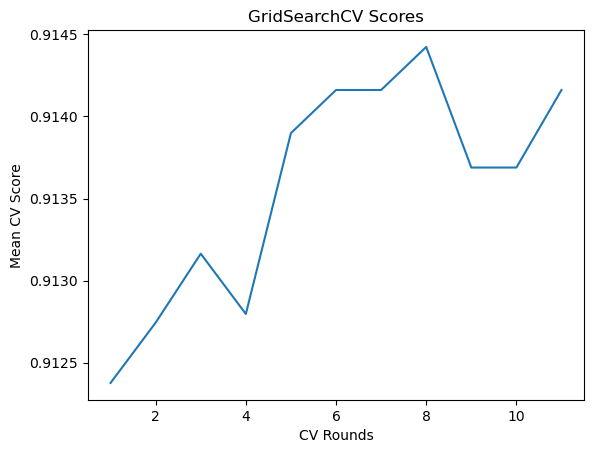

In [159]:
# 평균 교차 검증 점수 추출
mean_scores = SVC_CV.cv_results_['mean_test_score']

# 교차 검증 회차 (1부터 시작)
cv_rounds = list(range(1, 12))

# 평균 점수 그래프로 표시
plt.plot(cv_rounds, mean_scores)
plt.xlabel('CV Rounds')
plt.ylabel('Mean CV Score')
plt.title('GridSearchCV Scores')
plt.show()


## 로지스틱 회귀

In [160]:

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs')

eva(lr, train_scaled, test_scaled, y_train, y_test)

----LogisticRegression----
train정확도:0.8928590167374993,test정확도:0.8783, 정밀도:0.8515, 재현율:0.8308, F1:0.8402


In [161]:
lr_ovo = OneVsRestClassifier(LogisticRegression(random_state=42))
eva(lr, train_scaled, test_scaled, y_train, y_test)

----LogisticRegression----
train정확도:0.8928590167374993,test정확도:0.8783, 정밀도:0.8515, 재현율:0.8308, F1:0.8402


## knn

In [162]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
eva(lr, train_scaled, test_scaled, y_train, y_test)

----LogisticRegression----
train정확도:0.8928590167374993,test정확도:0.8783, 정밀도:0.8515, 재현율:0.8308, F1:0.8402


## Boosting

In [101]:
!pip install xgboost

In [163]:
from xgboost import XGBClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42, objective='multiclass')
eva(xgb, X_train, X_test, y_train, y_test)


----XGBClassifier----
train정확도:0.9998950627000367,test정확도:0.9161, 정밀도:0.8994, 재현율:0.8869, F1:0.8922


In [103]:
!pip install lightgbm

In [164]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42, objective='multiclass')
eva(lgb, X_train, X_test, y_train, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15030
[LightGBM] [Info] Number of data points in the train set: 19059, number of used features: 59
[LightGBM] [Info] Start training from score -1.782515
[LightGBM] [Info] Start training from score -3.803206
[LightGBM] [Info] Start training from score -1.608337
[LightGBM] [Info] Start training from score -0.955973
[LightGBM] [Info] Start training from score -1.969213
[LightGBM] [Info] Start training from score -5.084610
[LightGBM] [Info] Start training from score -3.417543
[LightGBM] [Info] Start training from score -3.073103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

## 랜덤포레스트

In [165]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(n_jobs=-1, random_state=42)
eva(rf, X_train, X_test, y_train, y_test)

----RandomForestClassifier----
train정확도:0.9998950627000367,test정확도:0.9051, 정밀도:0.9005, 재현율:0.8582, F1:0.8750


- xgboost의 성능이 가장 좋았다

## 보팅

In [166]:
from sklearn.ensemble import VotingClassifier

xgb = XGBClassifier(tree_method='hist', random_state=42)
lgb = LGBMClassifier(random_state=42, objective='multiclass',verbose=-1)
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# 소프트 보팅으로 구현
vo = VotingClassifier(estimators=[('XGB', xgb),('LGB', lgb),('RF', rf)], voting='hard')

eva(vo, X_train, X_test, y_train, y_test)

# 모델별 학습/예측/평가
models = [xgb, lgb, rf]
for model in models:
    eva(model, X_train, X_test, y_train, y_test)

----VotingClassifier----
train정확도:0.9998950627000367,test정확도:0.9177, 정밀도:0.9081, 재현율:0.8851, F1:0.8951
----XGBClassifier----
train정확도:0.9998950627000367,test정확도:0.9161, 정밀도:0.8994, 재현율:0.8869, F1:0.8922
----LGBMClassifier----
train정확도:0.999842594050055,test정확도:0.9155, 정밀도:0.9071, 재현율:0.8764, F1:0.8906
----RandomForestClassifier----
train정확도:0.9998950627000367,test정확도:0.9051, 정밀도:0.9005, 재현율:0.8582, F1:0.8750


# 데이터 불균형 처리

- Training target statistics: Counter({3: 7327, 2: 3816, 0: 3206, 4: 2660, 7: 882, 6: 625, 1: 425, 5: 118})
- Testing target statistics: Counter({3: 2346, 2: 1292, 0: 1084, 4: 925, 7: 305, 6: 240, 1: 130, 5: 31})

In [143]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_train_over, y_train_over = sm.fit_resample(train_scaled,y_train)
print(train_scaled.shape, y_train.shape)
print(x_train_over.shape, y_train_over.shape)
print(pd.Series(y_train_over).value_counts())

(19059, 59) (19059,)
(58616, 59) (58616,)
2    7327
4    7327
3    7327
0    7327
1    7327
7    7327
6    7327
5    7327
dtype: int64


In [150]:
xgb = XGBClassifier(tree_method='hist', random_state=42, objective='multiclass')
eva(xgb, x_train_over, test_scaled, y_train_over, y_test)

----XGBClassifier----
train정확도:0.9999488194349666,test정확도:0.9155, 정밀도:0.8813, 재현율:0.9053, F1:0.8927


- 재현율 : 0.8869 -> 0.9053, 정확도 : 0.9161 -> 0.9155

In [148]:
from sklearn.ensemble import VotingClassifier


xgb = XGBClassifier(tree_method='hist', random_state=42)
lgb = LGBMClassifier(random_state=42, objective='multiclass',verbose=-1)
rf = RandomForestClassifier(n_jobs=-1, random_state=42)

# 소프트 보팅으로 구현
vo = VotingClassifier(estimators=[('XGB', xgb),('LGB', lgb),('RF', rf)], voting='hard')

eva(vo, x_train_over, test_scaled, y_train_over, y_test)

# 모델별 학습/예측/평가
models = [xgb, lgb, rf]
for model in models:
    eva(model, x_train_over, test_scaled, y_train_over, y_test)

----VotingClassifier----
train정확도:0.9999488194349666,test정확도:0.9172, 정밀도:0.8920, 재현율:0.9082, F1:0.8997
----XGBClassifier----
train정확도:0.9999488194349666,test정확도:0.9155, 정밀도:0.8813, 재현율:0.9053, F1:0.8927
----LGBMClassifier----
train정확도:0.9992664119011874,test정확도:0.9139, 정밀도:0.8899, 재현율:0.9065, F1:0.8978
----RandomForestClassifier----
train정확도:0.9999658796233111,test정확도:0.9065, 정밀도:0.8808, 재현율:0.8961, F1:0.8880


# 하이퍼파라미터 튜닝

- SVC의 ovo전략으로 하이퍼파라미터 튜닝 한 것보다 위의 모델의 성능들이 더 좋았다.
- xgboost를 튜닝을 하여 정확도를 더 올릴 가능성이 있어보인다.

In [ ]:
xgb_clf = XGBClassifier(random_state=42)

params = {
    'max_depth': [3,4,5,6,7,8,9,10],
    'colsample_bytree': [0.8, 0.85, 0.9, 0.95, 1.0]
}

xgb_CV = GridSearchCV(xgb_clf, params, scoring='accuracy', cv=3, n_jobs=-1, verbose=1)
xgb_CV.fit(x_train_over,y_train_over)
xgb_best = xgb_CV.best_estimator_

eva(xgb_best, x_train_over, test_scaled, y_train_over, y_test)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


In [192]:
xgb = XGBClassifier(tree_method='hist', colsample_bytree=0.9,random_state=42, objective='multiclass')
eva(xgb, x_train_over, test_scaled, y_train_over, y_test)

----XGBClassifier----
train정확도:0.9999488194349666,test정확도:0.9175, 정밀도:0.8873, 재현율:0.9076, F1:0.8970
